In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm_notebook as tqdm

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os

class HealthyDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
        self.img_dir = img_dir  # Directory where the images are stored
        self.img_names = os.listdir(img_dir)  # List all files in the image directory
        self.transform1 = transform1  # First transformation to apply to the images
        self.transform2 = transform2  # Second transformation to apply to the images

        # Load and optionally transform all images in the directory
        self.imgs = []  # List to store the loaded images
        for img_name in self.img_names:            
            # Open each image
            img = Image.open(os.path.join(img_dir, img_name))

            # Apply the first transformation if it is defined
            if self.transform1 is not None:
                img = self.transform1(img)

            # Add the (transformed) image to the list
            self.imgs.append(img)

    def __getitem__(self, index):
        # Method to get an image by index
        img = self.imgs[index]  # Retrieve the image from the list

        # Apply the second transformation if it is defined
        if self.transform2 is not None:
            img = self.transform2(img)

        # Return the possibly transformed image
        return img

    def __len__(self):
        # Method to get the total number of images
        return len(self.imgs)  # Return the length of the image list

In [3]:
def prepareData(batch_size):
    # Image Preprocessing
    transform1 = transforms.Compose([
        transforms.Resize(64),        # Resize the image to 64x64 pixels
    #     transforms.CenterCrop(64)     # Crop the image to a 64x64 square centered on the middle of the image
    ])

    # Data augmentation and conversion to tensor
    random_transforms = [transforms.RandomRotation(degrees=5)]  # Define random rotation transformation
    transform2 = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the images horizontally with a probability of 0.5
    #     transforms.RandomApply(random_transforms, p=0.3),  # Apply the random rotation with a probability of 0.3
        transforms.ToTensor(),  # Convert the images to PyTorch tensors
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensors
    ])

    # Creating the dataset
    train_dataset = HealthyDataset(img_dir='/kaggle/input/healthy-images/Healthy',
                               transform1=transform1,
                               transform2=transform2)

    # DataLoader for the dataset
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,  # Load data in batches
                              shuffle=True,           # Shuffle the data to reduce model overfitting
                              num_workers=4)          # Number of subprocesses to use for data loading

    # Loading a batch of images
    imgs = next(iter(train_loader))  # Get the first batch of images
    imgs = imgs.numpy().transpose(0, 2, 3, 1)  # Convert the images from PyTorch tensor to numpy array and change the shape
    return train_loader, imgs

In [4]:
import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, channels_img = 3, features_d = 64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img = 3, features_g = 64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    if disc(x).shape == (N, 1, 1, 1): 
        print("Discriminator test passed")
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    if gen(z).shape == (N, in_channels, H, W):
        print("Generator test passed")

test()

Discriminator test passed
Generator test passed


In [5]:
# import torch.nn as nn

# # Generator class
# class Generator(nn.Module):
#     def __init__(self, nz=128, channels=3):
#         super(Generator, self).__init__()
        
#         # Initialize input and output channels
#         self.nz = nz
#         self.channels = channels
        
#         # Define a helper function to create a convolutional layer
#         def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
#             block = [
#                 nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
#                 nn.BatchNorm2d(n_output),
#                 nn.ReLU(inplace=True),
#             ]
#             return block

#         # Build the model
#         self.model = nn.Sequential(
#             *convlayer(self.nz, 1024, 4, 1, 0), # First layer: Fully connected layer achieved through convolution.
#             *convlayer(1024, 512, 4, 2, 1),    # Second layer
#             *convlayer(512, 256, 4, 2, 1),     # Third layer
#             *convlayer(256, 128, 4, 2, 1),     # Fourth layer
#             *convlayer(128, 64, 4, 2, 1),      # Fifth layer
#             nn.ConvTranspose2d(64, self.channels, 3, 1, 1), # Final layer to produce output with desired number of channels
#             nn.Tanh() # Tanh activation function for the output
#         )

#     # Forward pass through the generator
#     def forward(self, z):
#         # Reshape input noise vector z to a batch of images
#         z = z.view(-1, self.nz, 1, 1)
#         img = self.model(z)
#         return img

# # Discriminator class
# class Discriminator(nn.Module):
#     def __init__(self, channels=3):
#         super(Discriminator, self).__init__()
        
#         # Initialize input channels
#         self.channels = channels
#         # Define a helper function to create a convolutional layer
#         def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
#             block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
#             if bn:
#                 block.append(nn.BatchNorm2d(n_output))
#             block.append(nn.LeakyReLU(0.2, inplace=True))
#             return block

#         # Build the model
#         self.model = nn.Sequential(
#             *convlayer(self.channels, 32, 4, 2, 1),  # First layer
#             *convlayer(32, 64, 4, 2, 1),             # Second layer
#             *convlayer(64, 128, 4, 2, 1, bn=True),   # Third layer with batch normalization
#             *convlayer(128, 256, 4, 2, 1, bn=True),  # Fourth layer with batch normalization
#             nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # Final layer: Fully connected layer through convolution
#         )

#     # Forward pass through the discriminator
#     def forward(self, imgs):
#         # Pass the images through the model
#         out = self.model(imgs)
#         # Flatten the output
#         return out.view(-1, 1)

### UTILS (Gradient Penalty,)

In [6]:
import torch
import torch.nn as nn


def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


# def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
#     print("=> Saving checkpoint")
#     torch.save(state, filename)


# def load_checkpoint(checkpoint, gen, disc):
#     print("=> Loading checkpoint")
#     gen.load_state_dict(checkpoint['gen'])
#     disc.load_state_dict(checkpoint['disc'])

In [7]:
def show_generated_img(noises, netG, netD, epoch):
    
#     print(f"\n Saving Model")
    print('*'* 10)
        # Save the Generator's state
    torch.save(netG.state_dict(), f'/kaggle/working/generator_ben_{epoch}.pth')  
    # 'netG.state_dict()' retrieves the state (weights and biases) of the generator network (netG).
    # This state is saved to a file named 'generator.pth'.
    # The '.pth' extension is commonly used for PyTorch model files.

    # Save the Discriminator's state
    torch.save(netD.state_dict(), f'/kaggle/working/discriminator_ben_{epoch}.pth')  
    # 'netD.state_dict()' retrieves the state (weights and biases) of the discriminator network (netD).
    # This state is saved to a file named 'discriminator.pth'.
    # The '.pth' extension is commonly used for PyTorch model files.

    # Generate images from the noise vectors using the generator
    gen_images = (netG(noises).to("cpu").clone().detach() + 1) / 2
    # 'netG(gen_z)' passes the noise vectors through the generator to produce a batch of images.
    # '.to("cpu")' moves the generated images to the CPU. This is necessary for converting them into numpy arrays later.
    # '.clone().detach()' creates a copy of the images and detaches them from the current computation graph.
    # '(... + 1) / 2' rescales the pixel values from the range [-1, 1] to [0, 1].
    # This rescaling is necessary because the generator often uses Tanh activation in the output layer, resulting in outputs in the range [-1, 1].
    
    # Convert the images to numpy arrays for visualization
    gen_images = gen_images.numpy().transpose(0, 2, 3, 1)  
    # '.numpy()' converts the tensor of generated images to a numpy array.
    # '.transpose(0, 2, 3, 1)' changes the shape of the array from [batch, channels, height, width] to [batch, height, width, channels].
    # This transposition is required for visualization purposes, as most visualization libraries expect the channel dimension to be last.
    
    # Create a figure for plotting the images
    fig = plt.figure(figsize=(25, 16))  
    # 'figsize=(25, 16)' sets the size of the figure to 25 inches wide and 16 inches tall.
    # This large size helps in better visualization of multiple images.

    # Loop through the generated images
    for ii, img in enumerate(gen_images):
        # Add a subplot for each image in the figure
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])  
        # '4, 8' means the grid will have 4 rows and 8 columns.
        # 'ii + 1' is the position of the subplot in the grid.
        # 'xticks=[]' and 'yticks=[]' remove the x and y axis tick marks for each subplot.

        # Display the image in the subplot
        plt.imshow(img)  
        # 'plt.imshow' displays the image. 'img' is the current image in the loop.

    # Show the complete figure with all subplots
    plt.show()

In [8]:
import matplotlib.pyplot as plt

def trainData(batch_size, nz, epochs, lr, lambda_gp, num_disc_gen):
    train_loader, imgs = prepareData(batch_size)

    fig = plt.figure(figsize=(25, 16))

    # Loop through the images in the batch, limiting to the first 32 images
    for ii, img in enumerate(imgs[:32]):
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
        plt.imshow((img + 1) / 2)

    plt.show()
    # Creating the Generator network
    netG = Generator(nz).to(device)  
    # Initialize the Generator with the specified noise vector size (nz).
    # The .to(device) method moves the model to a GPU if available, otherwise to the CPU.

    # Creating the Discriminator network
    netD = Discriminator().to(device)
    # Initialize the Discriminator.
    # The .to(device) method moves the model to a GPU if available, otherwise to the CPU.

    # Setting up the loss function
    criterion = nn.BCELoss()  
    # Binary Cross Entropy Loss is used, typical for GANs as the discriminator outputs a binary classification (real or fake).

    # Setting up the Optimizer for the Discriminator

    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))  
    # Use the Adam optimizer for the discriminator.
    # 'lr' is the learning rate, and 'betas' are the hyperparameters for the Adam optimizer.

    # Setting up the Optimizer for the Generator
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))  
    # Use the Adam optimizer for the generator, similar to the discriminator.

    # Creating a fixed noise vector for evaluating the Generator's performance
    fixed_noise = torch.randn(32, nz, 1, 1, device=device)  
    # Generate a fixed random noise vector with 25 samples, each of size 'nz'.
    # The noise vector is used to evaluate the generator's output.
    # The .to(device) method moves the noise vector to the same device as the model.
    # Loop over all epochs
    print('*'* 10)
    print(f"\n Starting Training with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}, lambda_gp = {lambda_gp}, critic_size = {num_disc_gen}")
    print('*'* 10)
    for epoch in range(epochs):

        # Loop over the batches of images
#         for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        for ii, real_images in enumerate(train_loader):
            for _ in range(num_disc_gen):
                # Update Discriminator network:
                # ----------------------------
                netD.zero_grad()  # Reset gradients for the discriminator

                # Move real images to the appropriate device (GPU or CPU)
                real_images = real_images.to(device)

                # Create labels for real images
                batch_size = real_images.size(0)
                labels = torch.full((batch_size, 1), real_label, device=device)

                # Forward pass real images through D
                outputR = netD(real_images)

                # Generate fake images with G
                noise = torch.randn(batch_size, nz, 1, 1, device=device)
                fake = netG(noise)

                # Forward pass fake images through D
                outputF = netD(fake.detach())
                
                # Calculate Gradient Penalty
                gp = gradient_penalty(netD, real_images, fake, device = device)

                # Calculate loss for D and perform backward pass
                errD = (-(torch.mean(outputR) - torch.mean(outputF))+ lambda_gp*gp)
                errD.backward(retain_graph=True)
                optimizerD.step()

            # Update Generator network:
            # -------------------------
            netG.zero_grad()  # Reset gradients for the generator

            # Forward pass fake images through D again
            outputF = netD(fake)

            # Calculate loss for G and perform backward pass
            errG = -torch.mean(outputF)
            errG.backward()
            optimizerG.step()

            # Print statistics
            if (ii+1) % (len(train_loader)//2) == 0:
                print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                      % (epoch + 1, epochs, ii+1, len(train_loader),
                         errD.item(), errG.item()))

        # Show a generated image after each epoch
        if epoch%100 == 0:
            print('Generating images for:', epoch, ' epochs')
            show_generated_img(fixed_noise, netG, netD, epoch)
    
    print('*'* 10)
    print(f"\n Finished Training with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}, lambda_gp = {lambda_gp}, critic_size = {num_disc_gen}")
    print('*'* 10)  
    
    print(f"\n Saving Model")
    print('*'* 10)
        # Save the Generator's state
    torch.save(netG.state_dict(), f'/kaggle/working/gen_{lr}_{batch_size}_{epochs}_{nz}_{lambda_gp}_{num_disc_gen}.pth')  
    # 'netG.state_dict()' retrieves the state (weights and biases) of the generator network (netG).
    # This state is saved to a file named 'generator.pth'.
    # The '.pth' extension is commonly used for PyTorch model files.

    # Save the Discriminator's state
    torch.save(netD.state_dict(), f'/kaggle/working/disc_{lr}_{batch_size}_{epochs}_{nz}_{lambda_gp}_{num_disc_gen}.pth')  
    # 'netD.state_dict()' retrieves the state (weights and biases) of the discriminator network (netD).
    # This state is saved to a file named 'discriminator.pth'.
    # The '.pth' extension is commonly used for PyTorch model files.
    
    print('*'* 10)
    print(f"\n Generating Images with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}, lambda_gp = {lambda_gp}, critic_size = {num_disc_gen}")
    print('*'* 10)
    
    # Generate random noise vectors
    gen_z = torch.randn(32, nz, 1, 1, device=device)  
    # This creates a batch of 32 random noise vectors, each of size 'nz'.
    # The noise vectors are the input to the generator.
    # The dimensions of the tensor are [batch_size, nz, 1, 1].
    # 'device=device' ensures that the operation is performed on the same device (GPU/CPU) as the model.

    # Generate images from the noise vectors using the generator
    gen_images = (netG(gen_z).to("cpu").clone().detach() + 1) / 2
    # 'netG(gen_z)' passes the noise vectors through the generator to produce a batch of images.
    # '.to("cpu")' moves the generated images to the CPU. This is necessary for converting them into numpy arrays later.
    # '.clone().detach()' creates a copy of the images and detaches them from the current computation graph.
    # '(... + 1) / 2' rescales the pixel values from the range [-1, 1] to [0, 1].
    # This rescaling is necessary because the generator often uses Tanh activation in the output layer, resulting in outputs in the range [-1, 1].

    # Convert the images to numpy arrays for visualization
    gen_images = gen_images.numpy().transpose(0, 2, 3, 1)  
    # '.numpy()' converts the tensor of generated images to a numpy array.
    # '.transpose(0, 2, 3, 1)' changes the shape of the array from [batch, channels, height, width] to [batch, height, width, channels].
    # This transposition is required for visualization purposes, as most visualization libraries expect the channel dimension to be last.
    
    # Create a figure for plotting the images
    fig = plt.figure(figsize=(25, 16))  
    # 'figsize=(25, 16)' sets the size of the figure to 25 inches wide and 16 inches tall.
    # This large size helps in better visualization of multiple images.

    # Loop through the generated images
    for ii, img in enumerate(gen_images):
        # Add a subplot for each image in the figure
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])  
        # '4, 8' means the grid will have 4 rows and 8 columns.
        # 'ii + 1' is the position of the subplot in the grid.
        # 'xticks=[]' and 'yticks=[]' remove the x and y axis tick marks for each subplot.

        # Display the image in the subplot
        plt.imshow(img)  
        # 'plt.imshow' displays the image. 'img' is the current image in the loop.

    # Show the complete figure with all subplots
    plt.show()
    
    
    print('*'* 10)
    print(f"\n Saving Images with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}, lambda_gp = {lambda_gp}, critic_size = {num_disc_gen}")
    print('*'* 10)
    
    if not os.path.exists(f'/kaggle/working/images_{lr}_{batch_size}_{epochs}_{nz}_{lambda_gp}_{num_disc_gen}'):
        os.mkdir(f'/kaggle/working/images_{lr}_{batch_size}_{epochs}_{nz}_{lambda_gp}_{num_disc_gen}')  
        # '../output_images' is the directory where generated images will be saved.
        # 'os.mkdir' creates the directory if it does not already exist.

    # Define batch size for image generation and total number of images to generate
    im_batch_size = 1  # Number of images to generate in each batch.
    n_images = 100    # Total number of images to generate.

    # Generate and save images in batches
    for i_batch in range(0, n_images, im_batch_size):
        # Generate a batch of noise vectors
        gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)  
        # 'torch.randn' generates a tensor of random values from a normal distribution.
        # The tensor has dimensions [im_batch_size, nz, 1, 1].

        # Generate images from the noise vectors
        gen_images = (netG(gen_z) + 1) / 2  
        # 'netG(gen_z)' generates a batch of images.
        # '(... + 1) / 2' rescales the images from [-1, 1] to [0, 1].

        # Prepare images for saving
        images = gen_images.to("cpu").clone().detach()  
        # Move images to CPU and detach from computation graph.
        images = images.numpy().transpose(0, 2, 3, 1)  
        # Convert to numpy array and change shape from [batch, channels, height, width] to [batch, height, width, channels].

#         Save each image in the batch to disk
        for i_image in range(gen_images.size(0)):
            # Construct the file path
            image_path = os.path.join(f'/kaggle/working/images_{lr}_{batch_size}_{epochs}_{nz}_{lambda_gp}_{num_disc_gen}', f'image_{i_batch+i_image:05d}.png')  
            # 'f'image_{i_batch+i_image:05d}.png'' formats the filename with leading zeros.

            # Save the image
            save_image(gen_images[i_image, :, :, :], image_path)  
            # 'save_image' saves the individual image to the specified path.

## Hyperparameter Tuning

In [9]:
nz_range = [30]  # Adjust the range and number of points as needed
epochs_range = [1000]  # Adjust the range and number of points as needed
lr_sizes = [0.001]  # Adjust the range and number of points as needed
batch_size_range = [16]  # You might want to keep batch size as specific values
# Possible values for batch_size, epochs, and nz
batch_sizes = batch_size_range  # Add more values as needed
epochs_values = epochs_range  # Add more values as needed
nz_values = nz_range  # Add more values as needed
lambda_gp_sizes = [10]
num_disc_gen_sizes = [2]


Training with lr = 0.001, batch_size=16, epochs=1000, nz=30, lambda_gp = 10, critic_size = 2


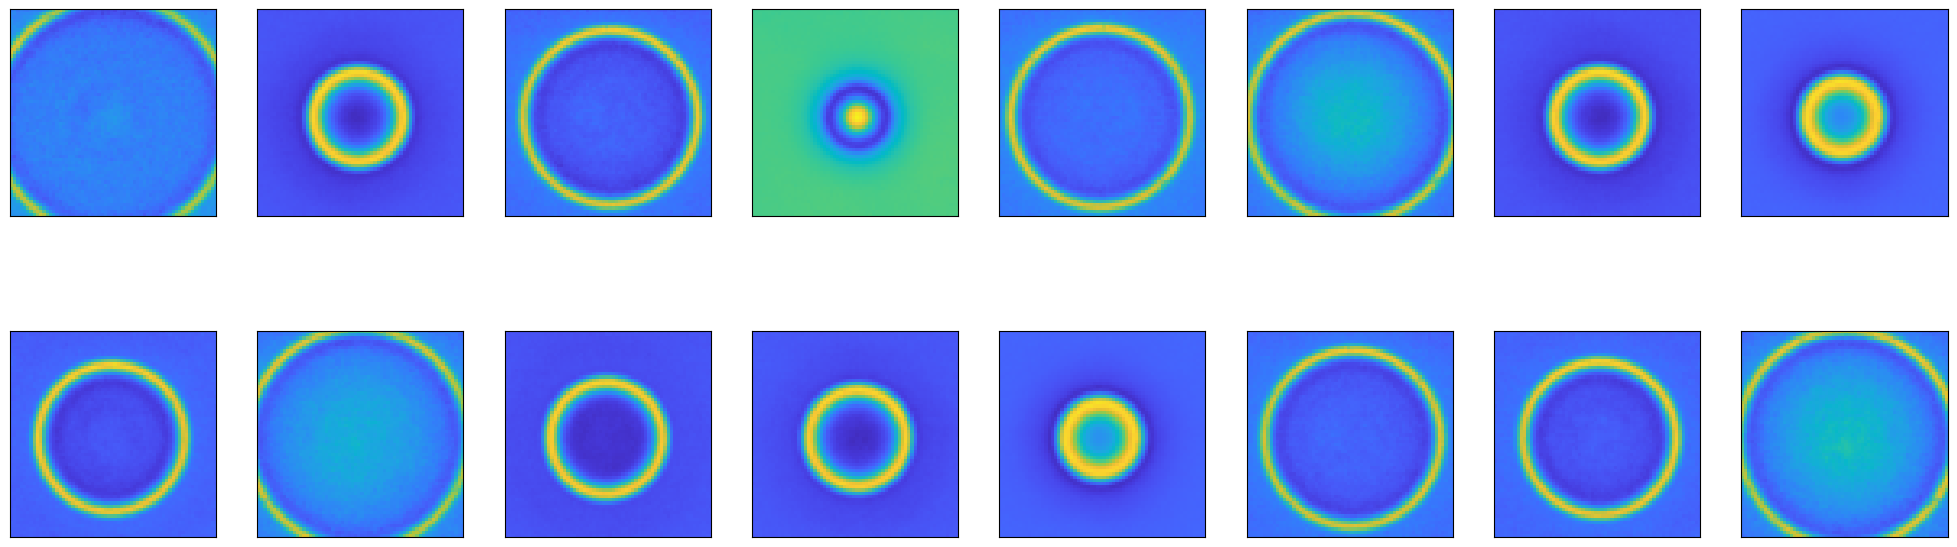

**********

 Starting Training with lr = 0.001, batch_size=16, epochs=1000, nz=30, lambda_gp = 10, critic_size = 2
**********
[1/1000][11/23] Loss_D: -27.7398 Loss_G: 18.2859
[1/1000][22/23] Loss_D: -39.2870 Loss_G: 17.8272
Generating images for: 0  epochs
**********


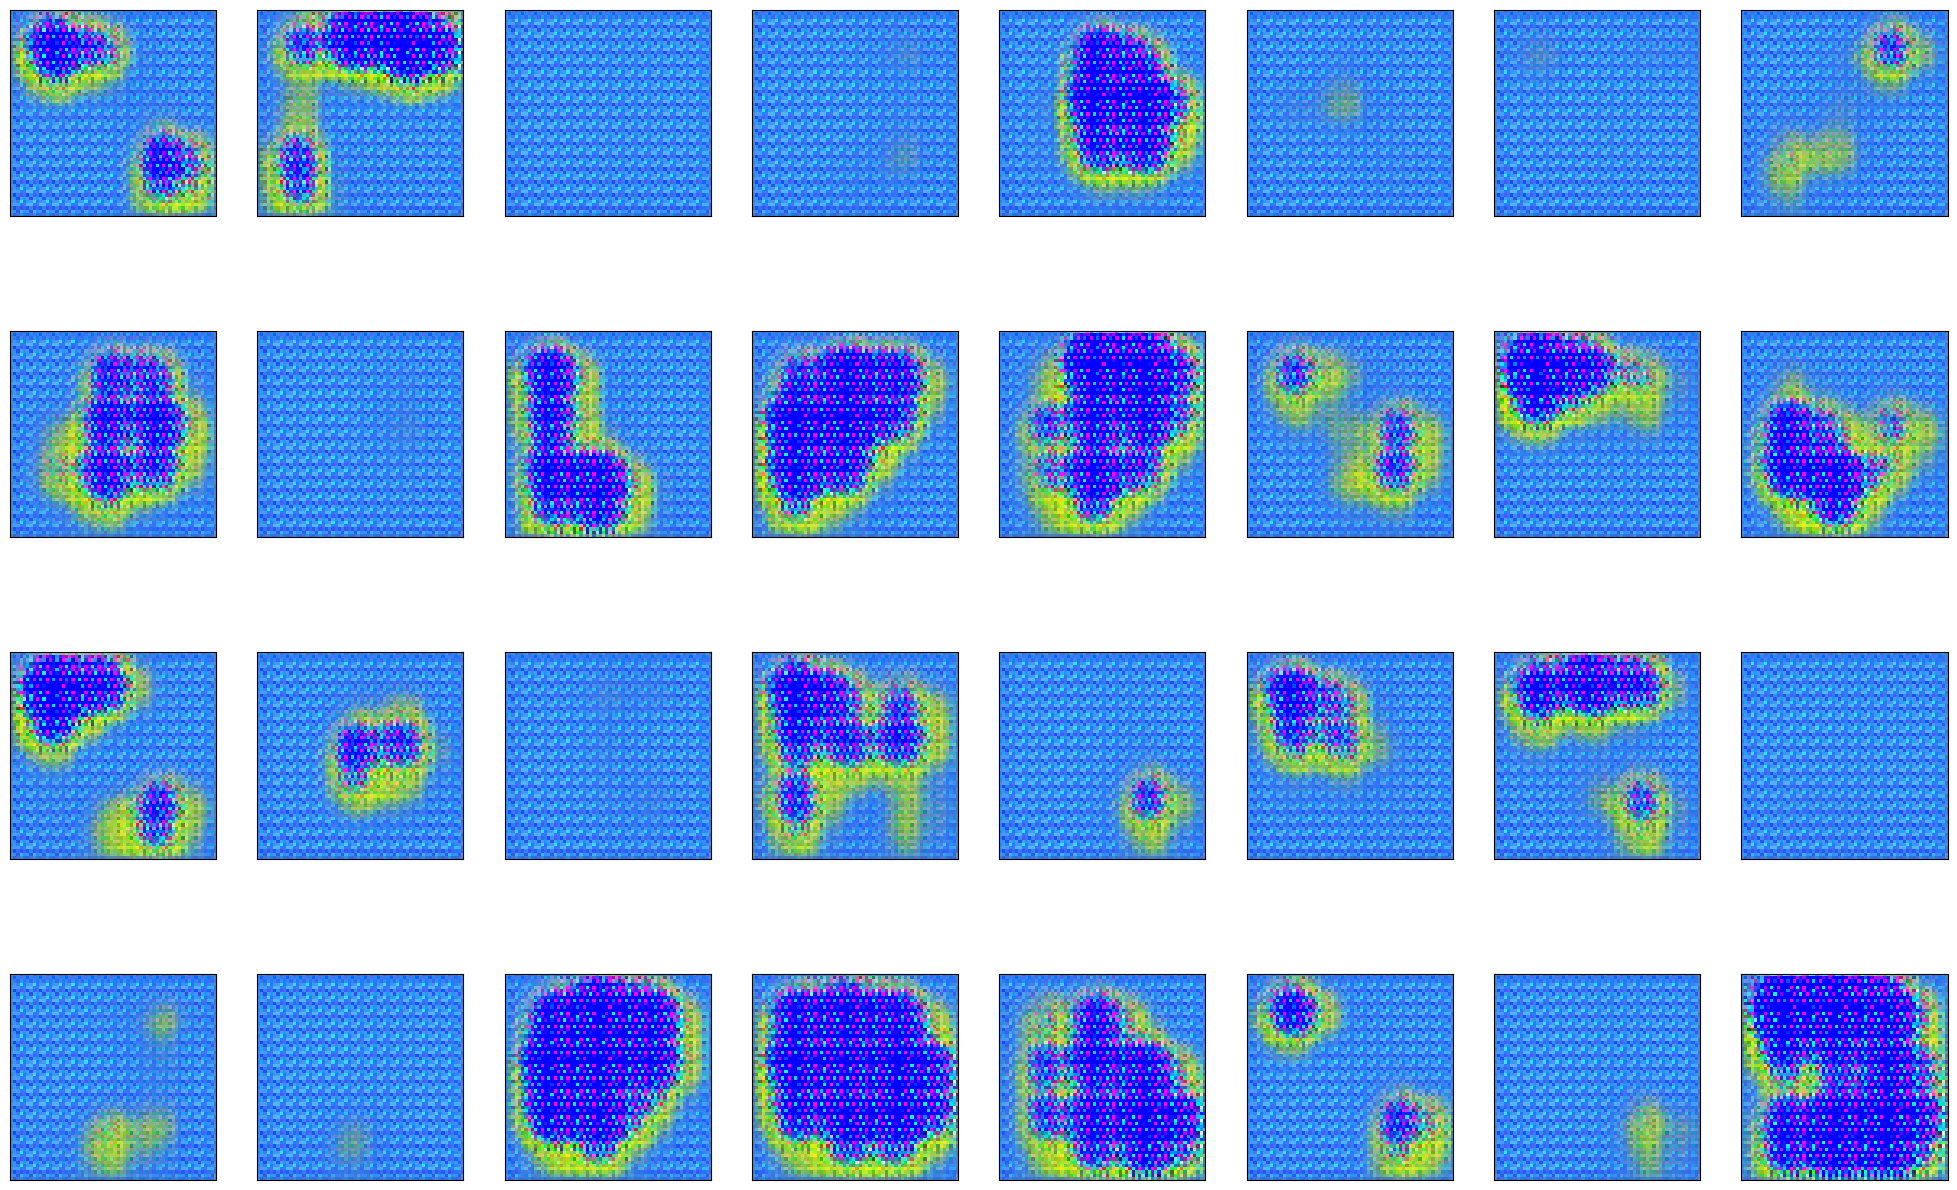

[2/1000][11/23] Loss_D: -50.6567 Loss_G: 36.8256
[2/1000][22/23] Loss_D: -45.3131 Loss_G: 32.4076
[3/1000][11/23] Loss_D: -53.0916 Loss_G: 44.6335
[3/1000][22/23] Loss_D: -47.2498 Loss_G: 64.5896
[4/1000][11/23] Loss_D: -68.4517 Loss_G: 67.2105
[4/1000][22/23] Loss_D: -42.4682 Loss_G: 68.9515
[5/1000][11/23] Loss_D: -64.1459 Loss_G: 93.3603
[5/1000][22/23] Loss_D: -55.6920 Loss_G: 67.2838
[6/1000][11/23] Loss_D: -41.7634 Loss_G: 123.4668
[6/1000][22/23] Loss_D: -54.3868 Loss_G: 133.4096
[7/1000][11/23] Loss_D: -67.1571 Loss_G: 137.1112
[7/1000][22/23] Loss_D: -50.4849 Loss_G: 150.0968
[8/1000][11/23] Loss_D: -58.1198 Loss_G: 137.1557
[8/1000][22/23] Loss_D: -43.9628 Loss_G: 131.2534
[9/1000][11/23] Loss_D: -34.0496 Loss_G: 141.1029
[9/1000][22/23] Loss_D: -39.7294 Loss_G: 112.8185
[10/1000][11/23] Loss_D: -29.9499 Loss_G: 138.0662
[10/1000][22/23] Loss_D: -41.4835 Loss_G: 97.5976
[11/1000][11/23] Loss_D: -45.7147 Loss_G: 115.8837
[11/1000][22/23] Loss_D: -39.1166 Loss_G: 136.9175
[12/1

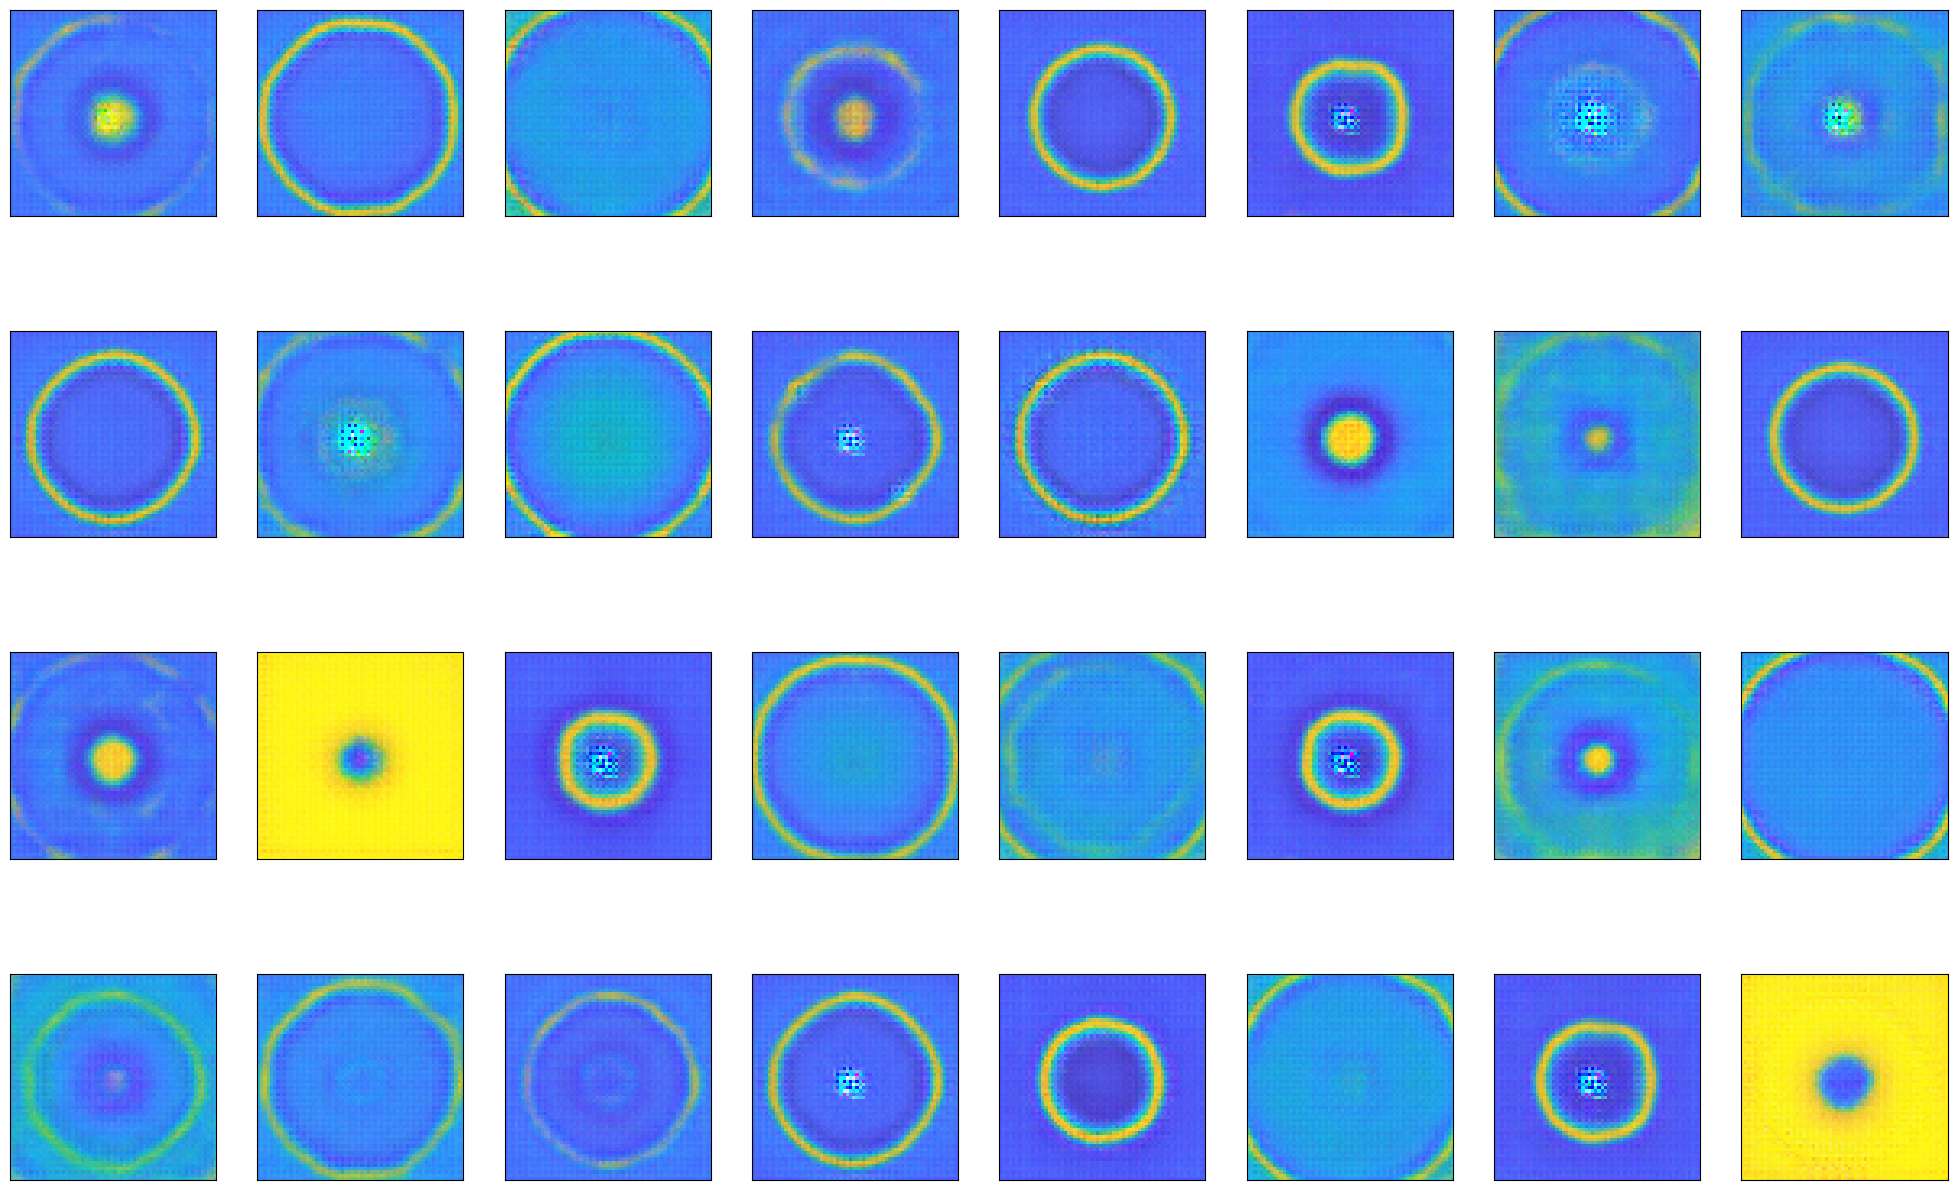

[102/1000][11/23] Loss_D: -14.4686 Loss_G: -40.1596
[102/1000][22/23] Loss_D: -4.5623 Loss_G: -37.6855
[103/1000][11/23] Loss_D: -5.9321 Loss_G: -39.5425
[103/1000][22/23] Loss_D: -37.7850 Loss_G: -9.4882
[104/1000][11/23] Loss_D: -17.2428 Loss_G: -25.2180
[104/1000][22/23] Loss_D: -5.8429 Loss_G: -38.0071
[105/1000][11/23] Loss_D: -11.4304 Loss_G: -30.1133
[105/1000][22/23] Loss_D: -12.2286 Loss_G: -35.9108
[106/1000][11/23] Loss_D: -5.0279 Loss_G: -47.0524
[106/1000][22/23] Loss_D: -7.3820 Loss_G: -31.1607
[107/1000][11/23] Loss_D: -17.4059 Loss_G: -27.2723
[107/1000][22/23] Loss_D: -13.2597 Loss_G: -36.9081
[108/1000][11/23] Loss_D: -19.8923 Loss_G: -19.2288
[108/1000][22/23] Loss_D: -8.4171 Loss_G: -41.7684
[109/1000][11/23] Loss_D: -9.6179 Loss_G: -34.2162
[109/1000][22/23] Loss_D: -0.6671 Loss_G: -40.1727
[110/1000][11/23] Loss_D: -10.6765 Loss_G: -33.7283
[110/1000][22/23] Loss_D: -15.2949 Loss_G: -28.2784
[111/1000][11/23] Loss_D: -8.4161 Loss_G: -48.7778
[111/1000][22/23] Loss

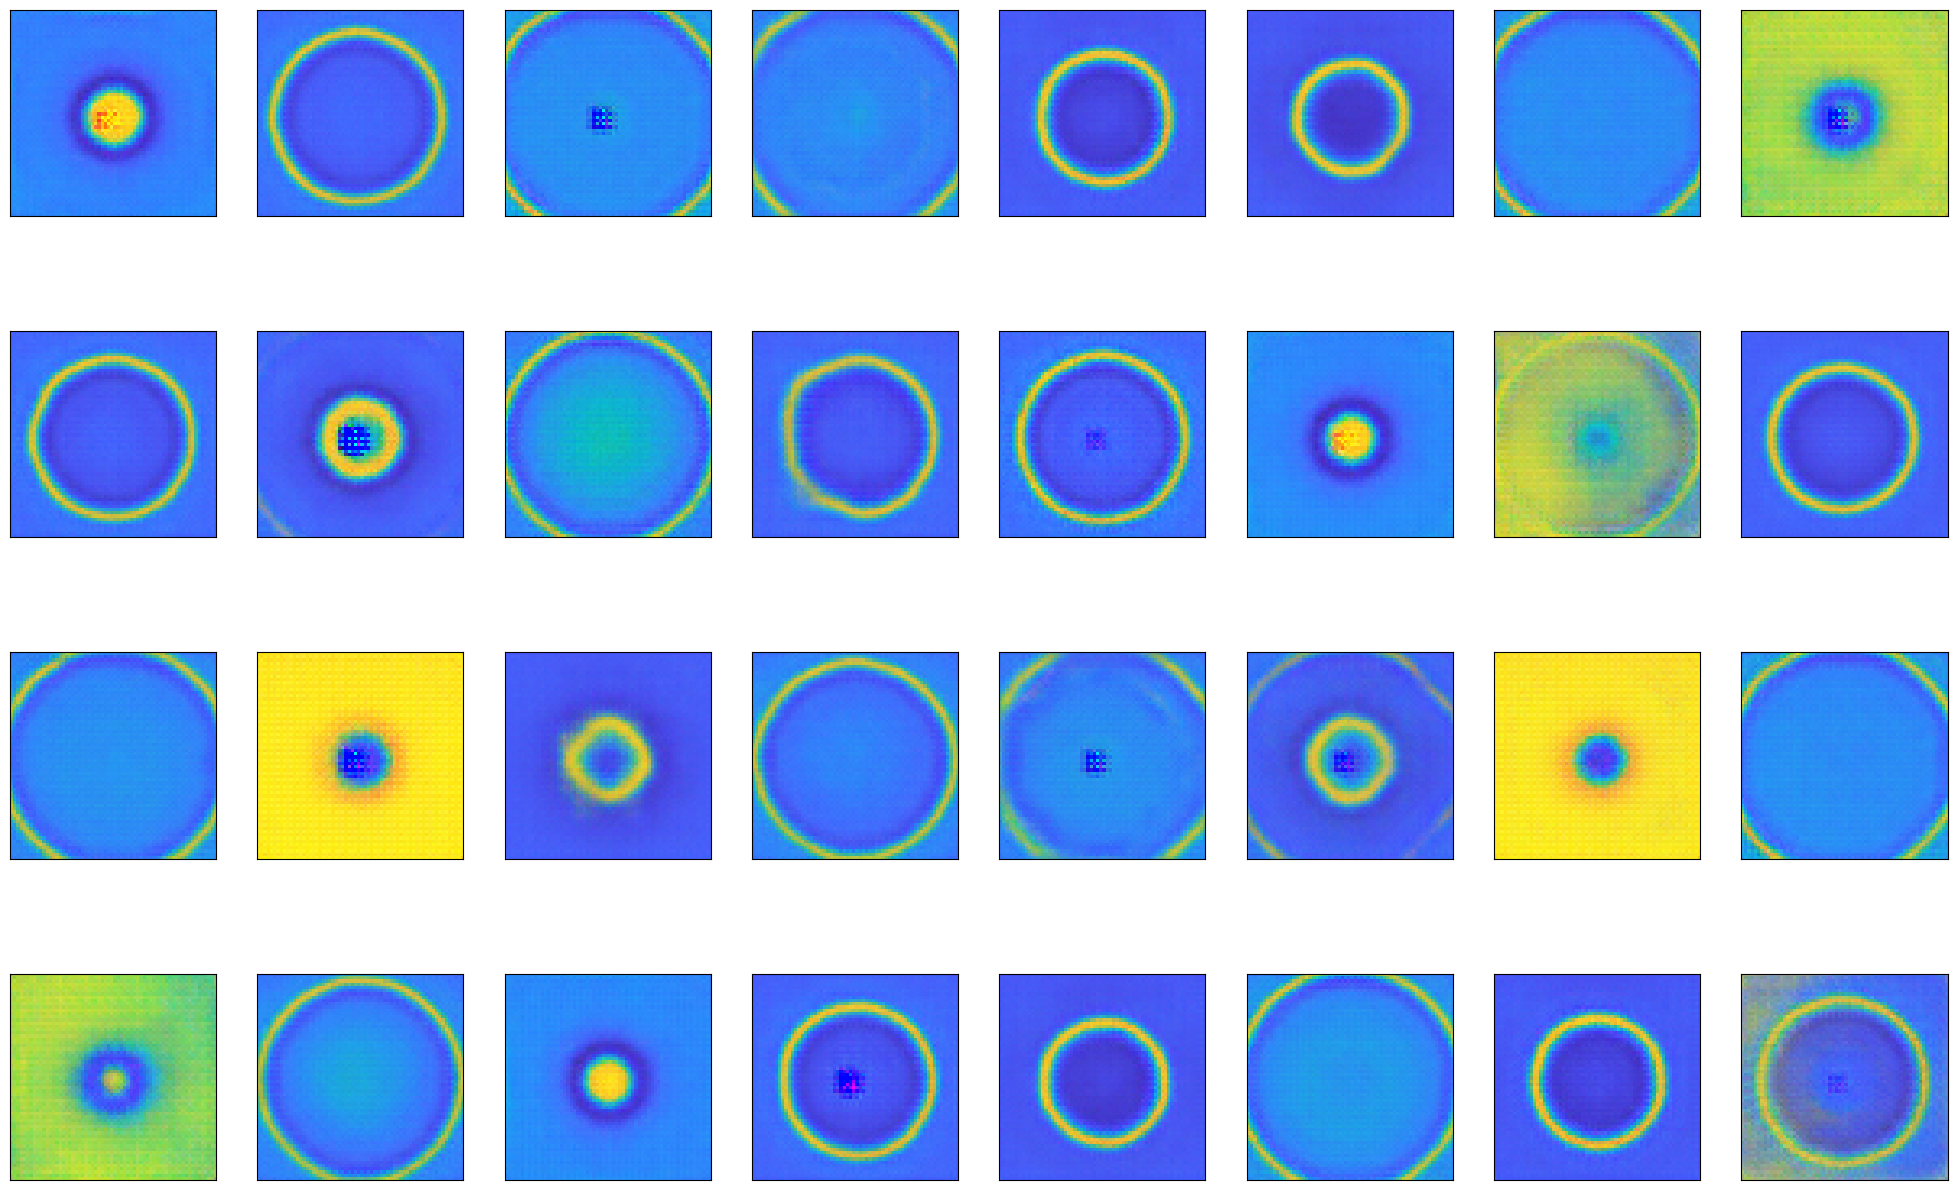

[202/1000][11/23] Loss_D: -10.6976 Loss_G: -106.1760
[202/1000][22/23] Loss_D: -9.2809 Loss_G: -102.7820
[203/1000][11/23] Loss_D: -7.1094 Loss_G: -104.3464
[203/1000][22/23] Loss_D: -11.8159 Loss_G: -96.2043
[204/1000][11/23] Loss_D: -6.9333 Loss_G: -107.7632
[204/1000][22/23] Loss_D: -0.5113 Loss_G: -116.6651
[205/1000][11/23] Loss_D: -16.9322 Loss_G: -114.1103
[205/1000][22/23] Loss_D: -12.1141 Loss_G: -99.8689
[206/1000][11/23] Loss_D: -0.0028 Loss_G: -108.1377
[206/1000][22/23] Loss_D: -4.4569 Loss_G: -120.3353
[207/1000][11/23] Loss_D: -13.0550 Loss_G: -120.4859
[207/1000][22/23] Loss_D: -7.6821 Loss_G: -119.8820
[208/1000][11/23] Loss_D: 6.5650 Loss_G: -120.7114
[208/1000][22/23] Loss_D: -10.5059 Loss_G: -97.8105
[209/1000][11/23] Loss_D: -4.8982 Loss_G: -96.9147
[209/1000][22/23] Loss_D: -1.6137 Loss_G: -98.5149
[210/1000][11/23] Loss_D: -0.8752 Loss_G: -103.2911
[210/1000][22/23] Loss_D: -10.5744 Loss_G: -92.0849
[211/1000][11/23] Loss_D: -9.4199 Loss_G: -92.8250
[211/1000][22

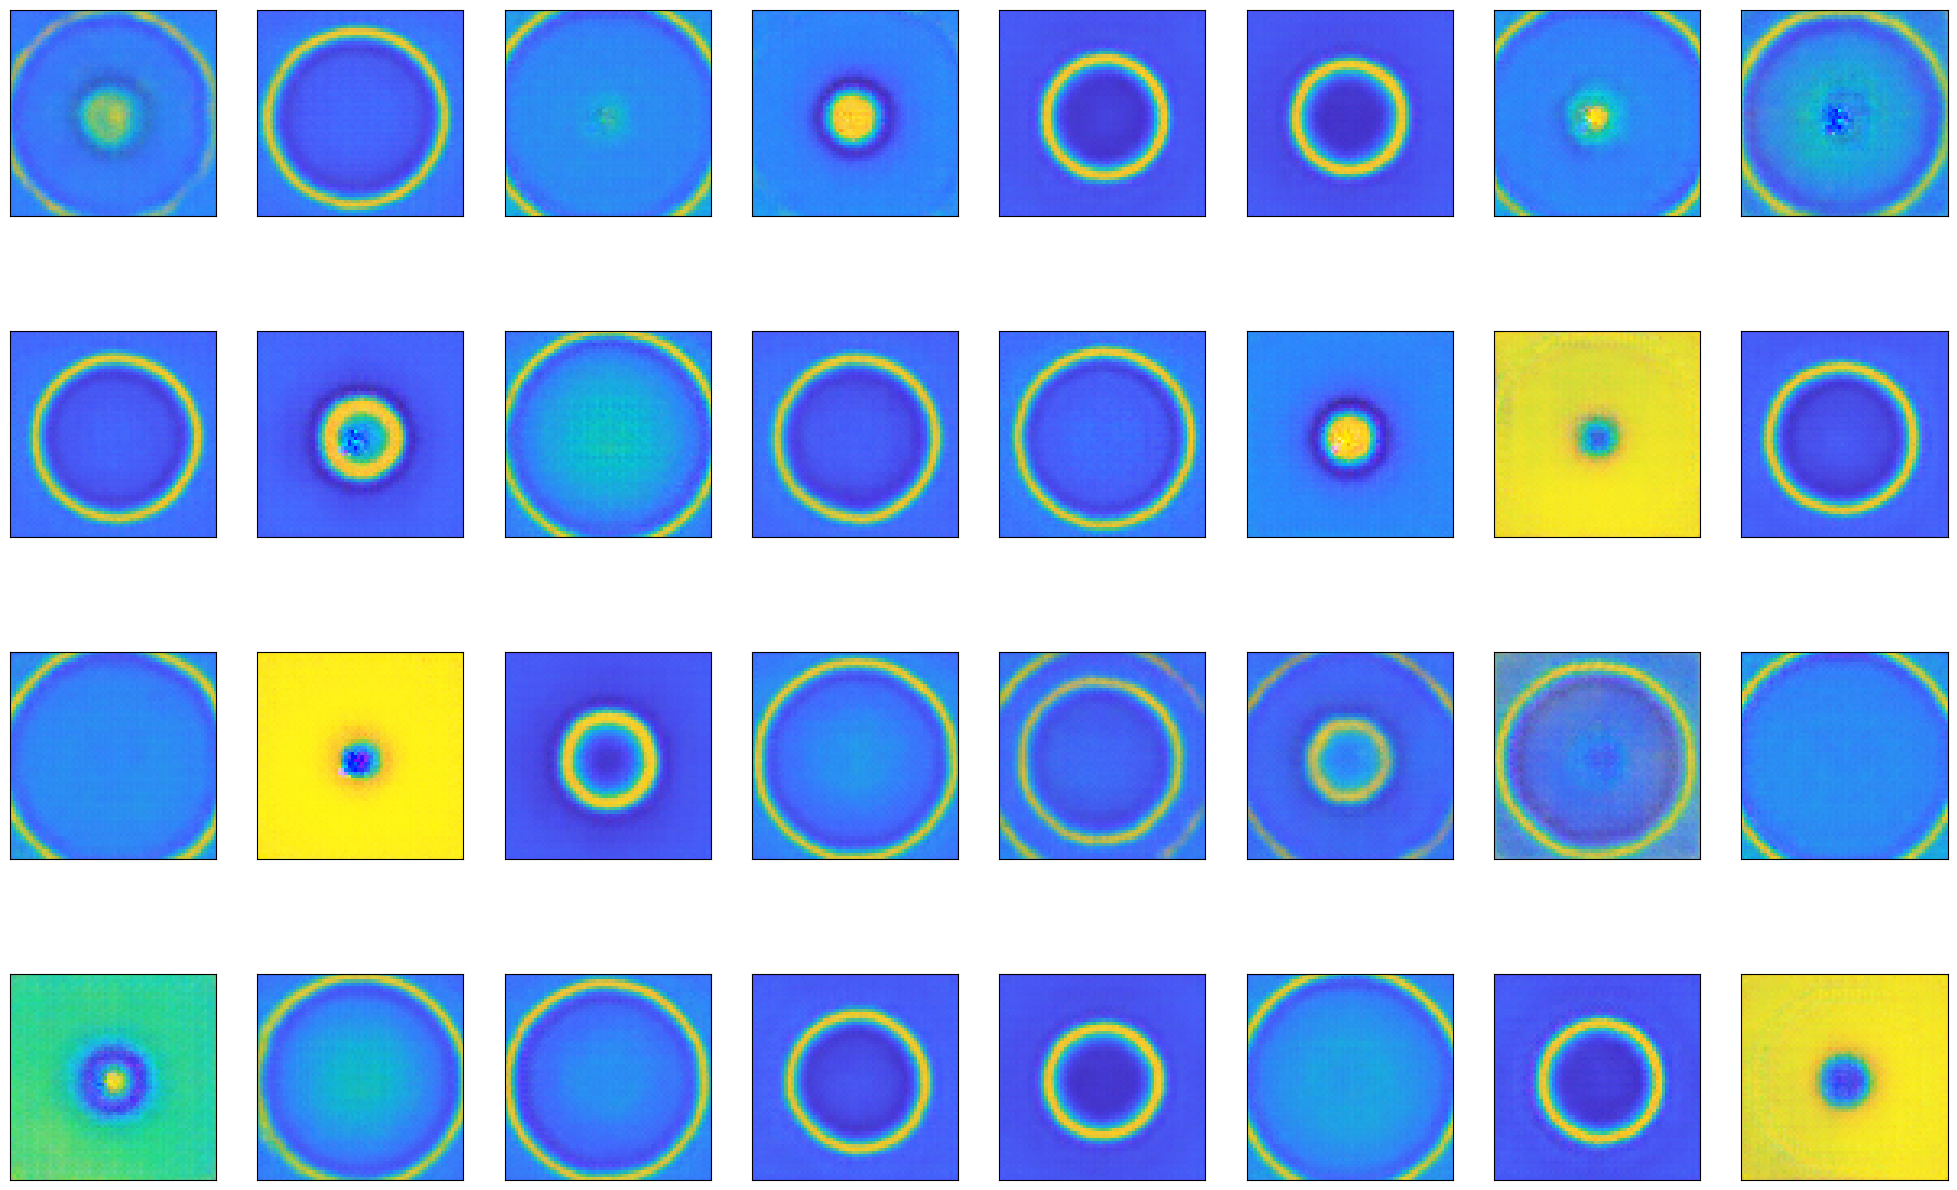

[302/1000][11/23] Loss_D: -5.8295 Loss_G: -156.4305
[302/1000][22/23] Loss_D: -4.4767 Loss_G: -156.6362
[303/1000][11/23] Loss_D: -0.4249 Loss_G: -165.5557
[303/1000][22/23] Loss_D: -2.7164 Loss_G: -151.9031
[304/1000][11/23] Loss_D: -3.1142 Loss_G: -158.6133
[304/1000][22/23] Loss_D: -1.5718 Loss_G: -156.5180
[305/1000][11/23] Loss_D: -5.1206 Loss_G: -161.2821
[305/1000][22/23] Loss_D: -11.5368 Loss_G: -147.2786
[306/1000][11/23] Loss_D: -3.1341 Loss_G: -153.1946
[306/1000][22/23] Loss_D: -8.8453 Loss_G: -155.2650
[307/1000][11/23] Loss_D: -3.7971 Loss_G: -148.1035
[307/1000][22/23] Loss_D: -4.2923 Loss_G: -156.7346
[308/1000][11/23] Loss_D: -11.6527 Loss_G: -148.0485
[308/1000][22/23] Loss_D: 5.0841 Loss_G: -149.1160
[309/1000][11/23] Loss_D: -24.8720 Loss_G: -132.0009
[309/1000][22/23] Loss_D: -14.5717 Loss_G: -148.4728
[310/1000][11/23] Loss_D: -11.8838 Loss_G: -145.2915
[310/1000][22/23] Loss_D: -1.6620 Loss_G: -162.0035
[311/1000][11/23] Loss_D: 3.6632 Loss_G: -141.9449
[311/1000

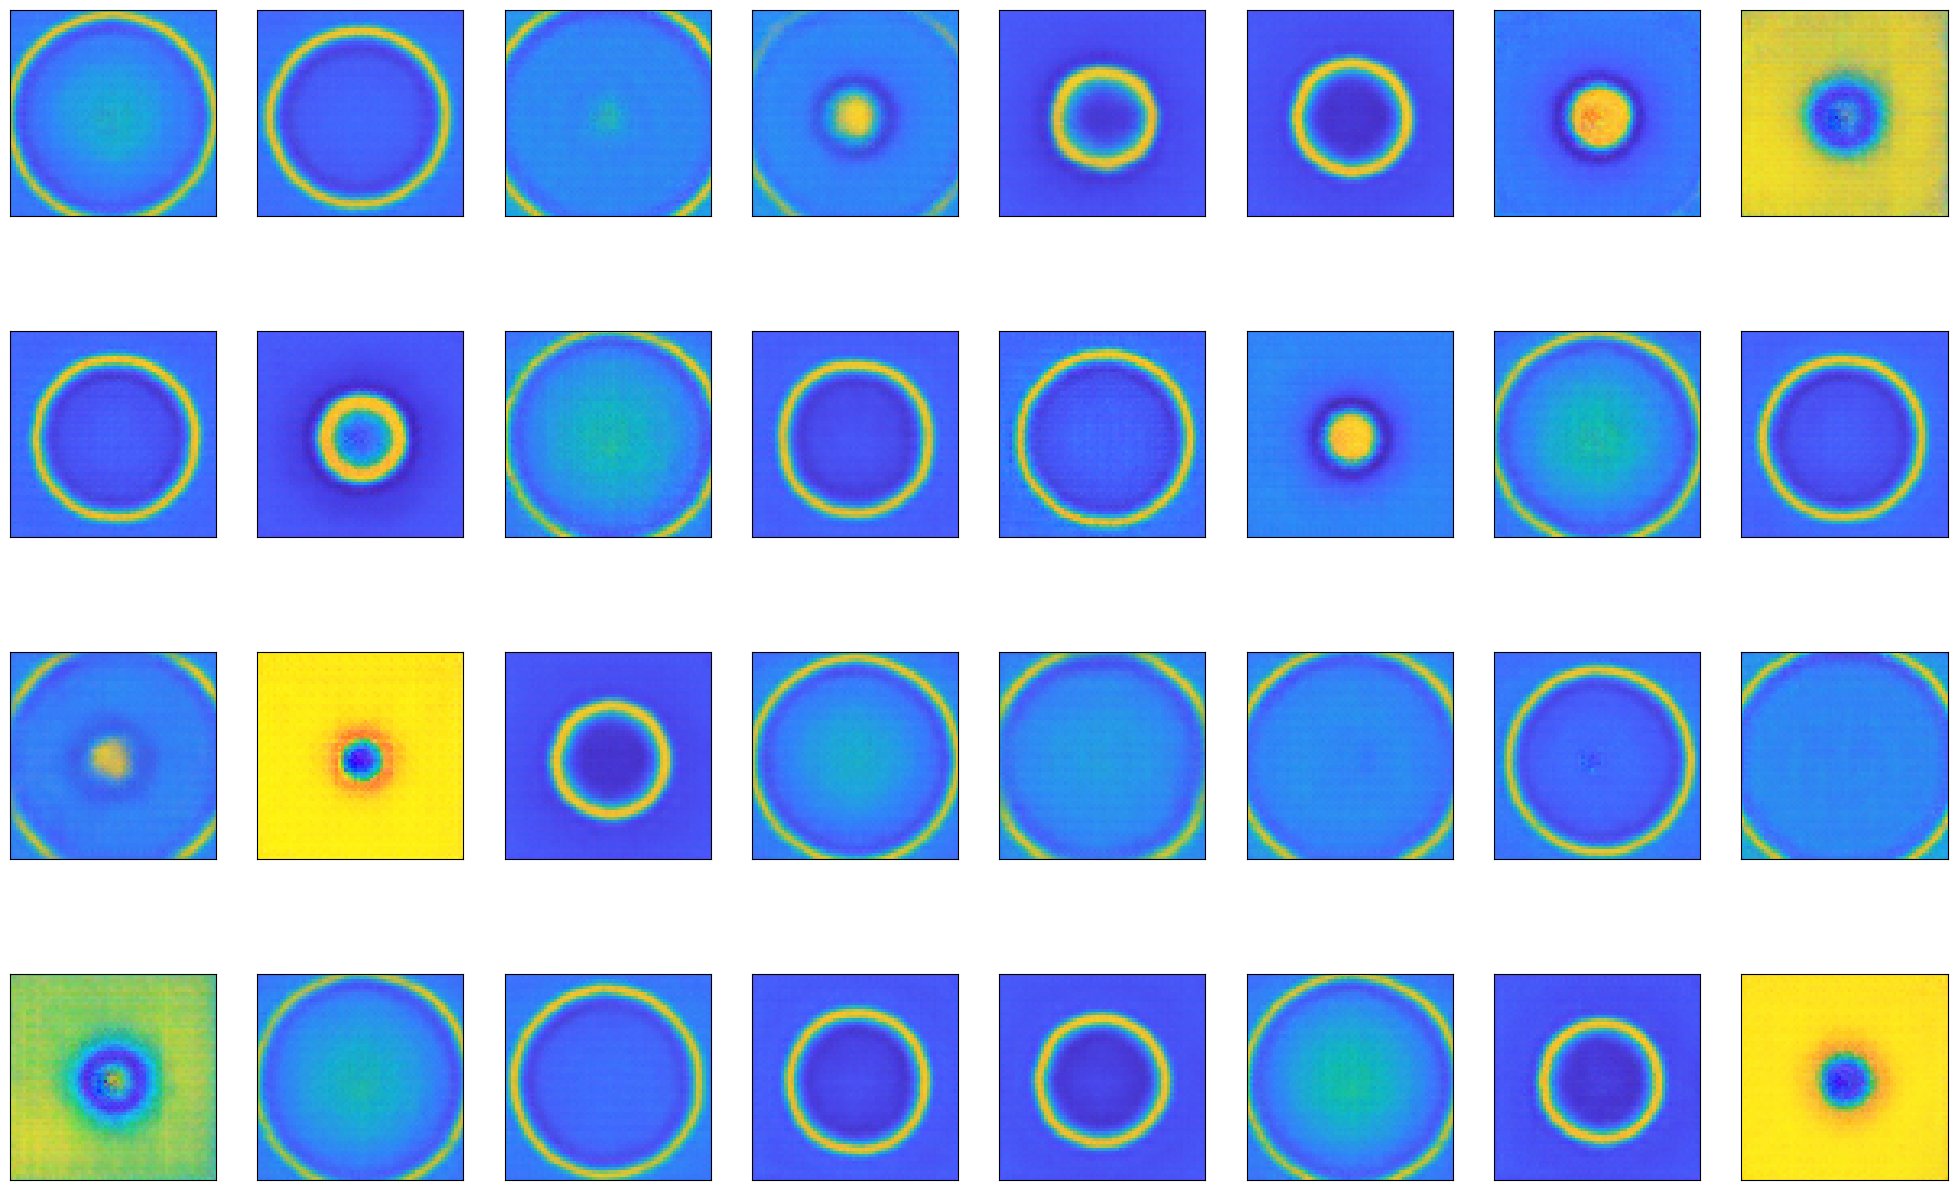

[402/1000][11/23] Loss_D: -8.2280 Loss_G: -160.4122
[402/1000][22/23] Loss_D: 2.8969 Loss_G: -167.6017
[403/1000][11/23] Loss_D: -2.0517 Loss_G: -170.5693
[403/1000][22/23] Loss_D: -5.3344 Loss_G: -181.3877
[404/1000][11/23] Loss_D: -4.9967 Loss_G: -172.5617
[404/1000][22/23] Loss_D: -8.5987 Loss_G: -171.0009
[405/1000][11/23] Loss_D: -8.3691 Loss_G: -180.2240
[405/1000][22/23] Loss_D: 0.8403 Loss_G: -174.3383
[406/1000][11/23] Loss_D: -11.1266 Loss_G: -163.9924
[406/1000][22/23] Loss_D: -3.8885 Loss_G: -171.6495
[407/1000][11/23] Loss_D: 0.7057 Loss_G: -169.8703
[407/1000][22/23] Loss_D: -3.6635 Loss_G: -171.9231
[408/1000][11/23] Loss_D: -2.5644 Loss_G: -166.6591
[408/1000][22/23] Loss_D: -1.4671 Loss_G: -169.1632
[409/1000][11/23] Loss_D: -5.7730 Loss_G: -172.6090
[409/1000][22/23] Loss_D: -3.1183 Loss_G: -172.4050
[410/1000][11/23] Loss_D: -4.1402 Loss_G: -168.8304
[410/1000][22/23] Loss_D: 0.4467 Loss_G: -173.1562
[411/1000][11/23] Loss_D: -1.2807 Loss_G: -174.8790
[411/1000][22/2

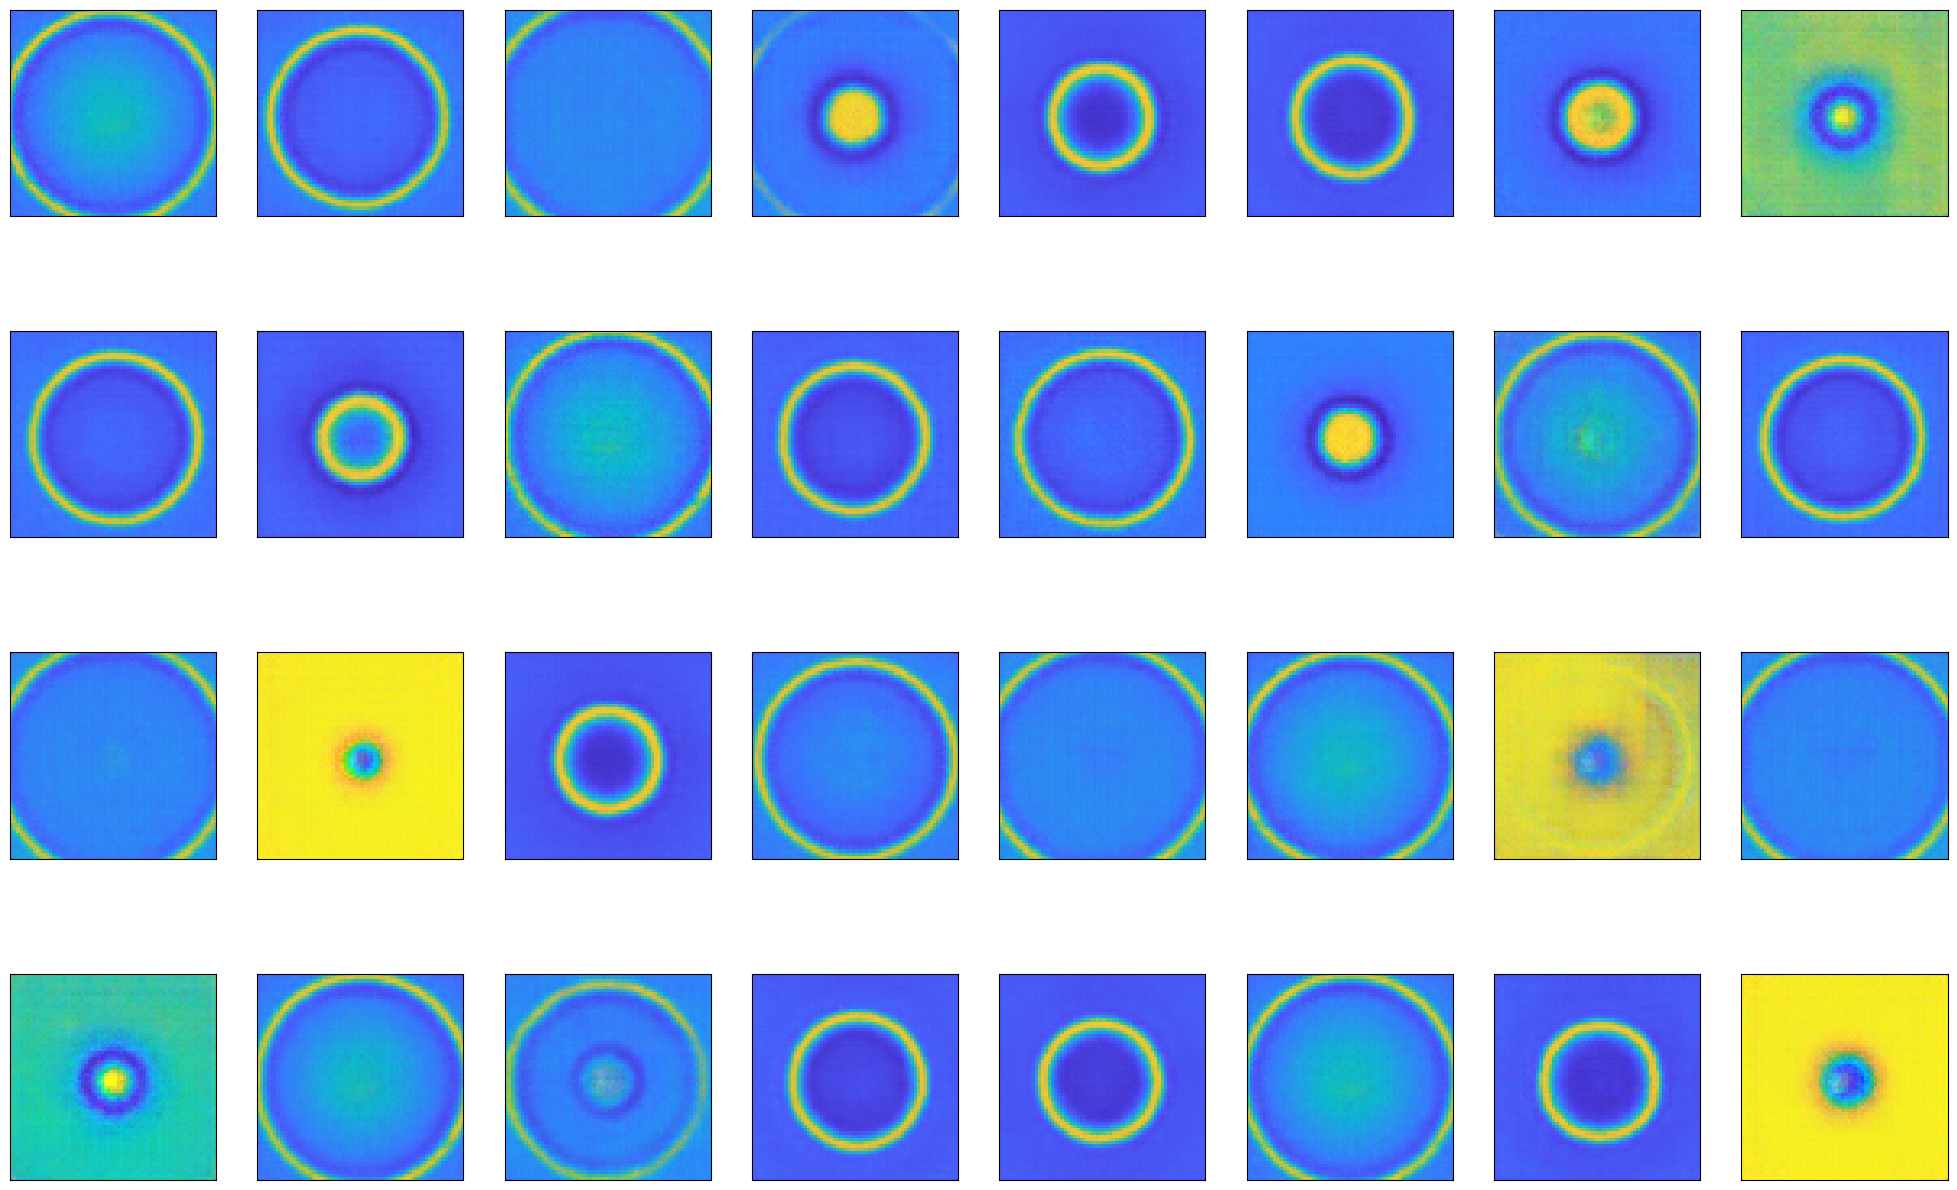

[502/1000][11/23] Loss_D: -4.9460 Loss_G: -199.9139
[502/1000][22/23] Loss_D: -8.6358 Loss_G: -201.9232
[503/1000][11/23] Loss_D: -2.9569 Loss_G: -198.3134
[503/1000][22/23] Loss_D: -5.8815 Loss_G: -202.3333
[504/1000][11/23] Loss_D: -8.9492 Loss_G: -194.4443
[504/1000][22/23] Loss_D: -6.9828 Loss_G: -194.8871
[505/1000][11/23] Loss_D: -2.4875 Loss_G: -191.5483
[505/1000][22/23] Loss_D: -10.3034 Loss_G: -196.4091
[506/1000][11/23] Loss_D: -13.2971 Loss_G: -196.4129
[506/1000][22/23] Loss_D: -4.1421 Loss_G: -191.7354
[507/1000][11/23] Loss_D: -0.9838 Loss_G: -202.4373
[507/1000][22/23] Loss_D: -2.4885 Loss_G: -198.0940
[508/1000][11/23] Loss_D: -1.4416 Loss_G: -203.5630
[508/1000][22/23] Loss_D: -8.8266 Loss_G: -194.6360
[509/1000][11/23] Loss_D: -4.3294 Loss_G: -207.2186
[509/1000][22/23] Loss_D: -6.1988 Loss_G: -199.7097
[510/1000][11/23] Loss_D: -2.2445 Loss_G: -201.5333
[510/1000][22/23] Loss_D: 0.7460 Loss_G: -199.6751
[511/1000][11/23] Loss_D: -5.5804 Loss_G: -196.7497
[511/1000][

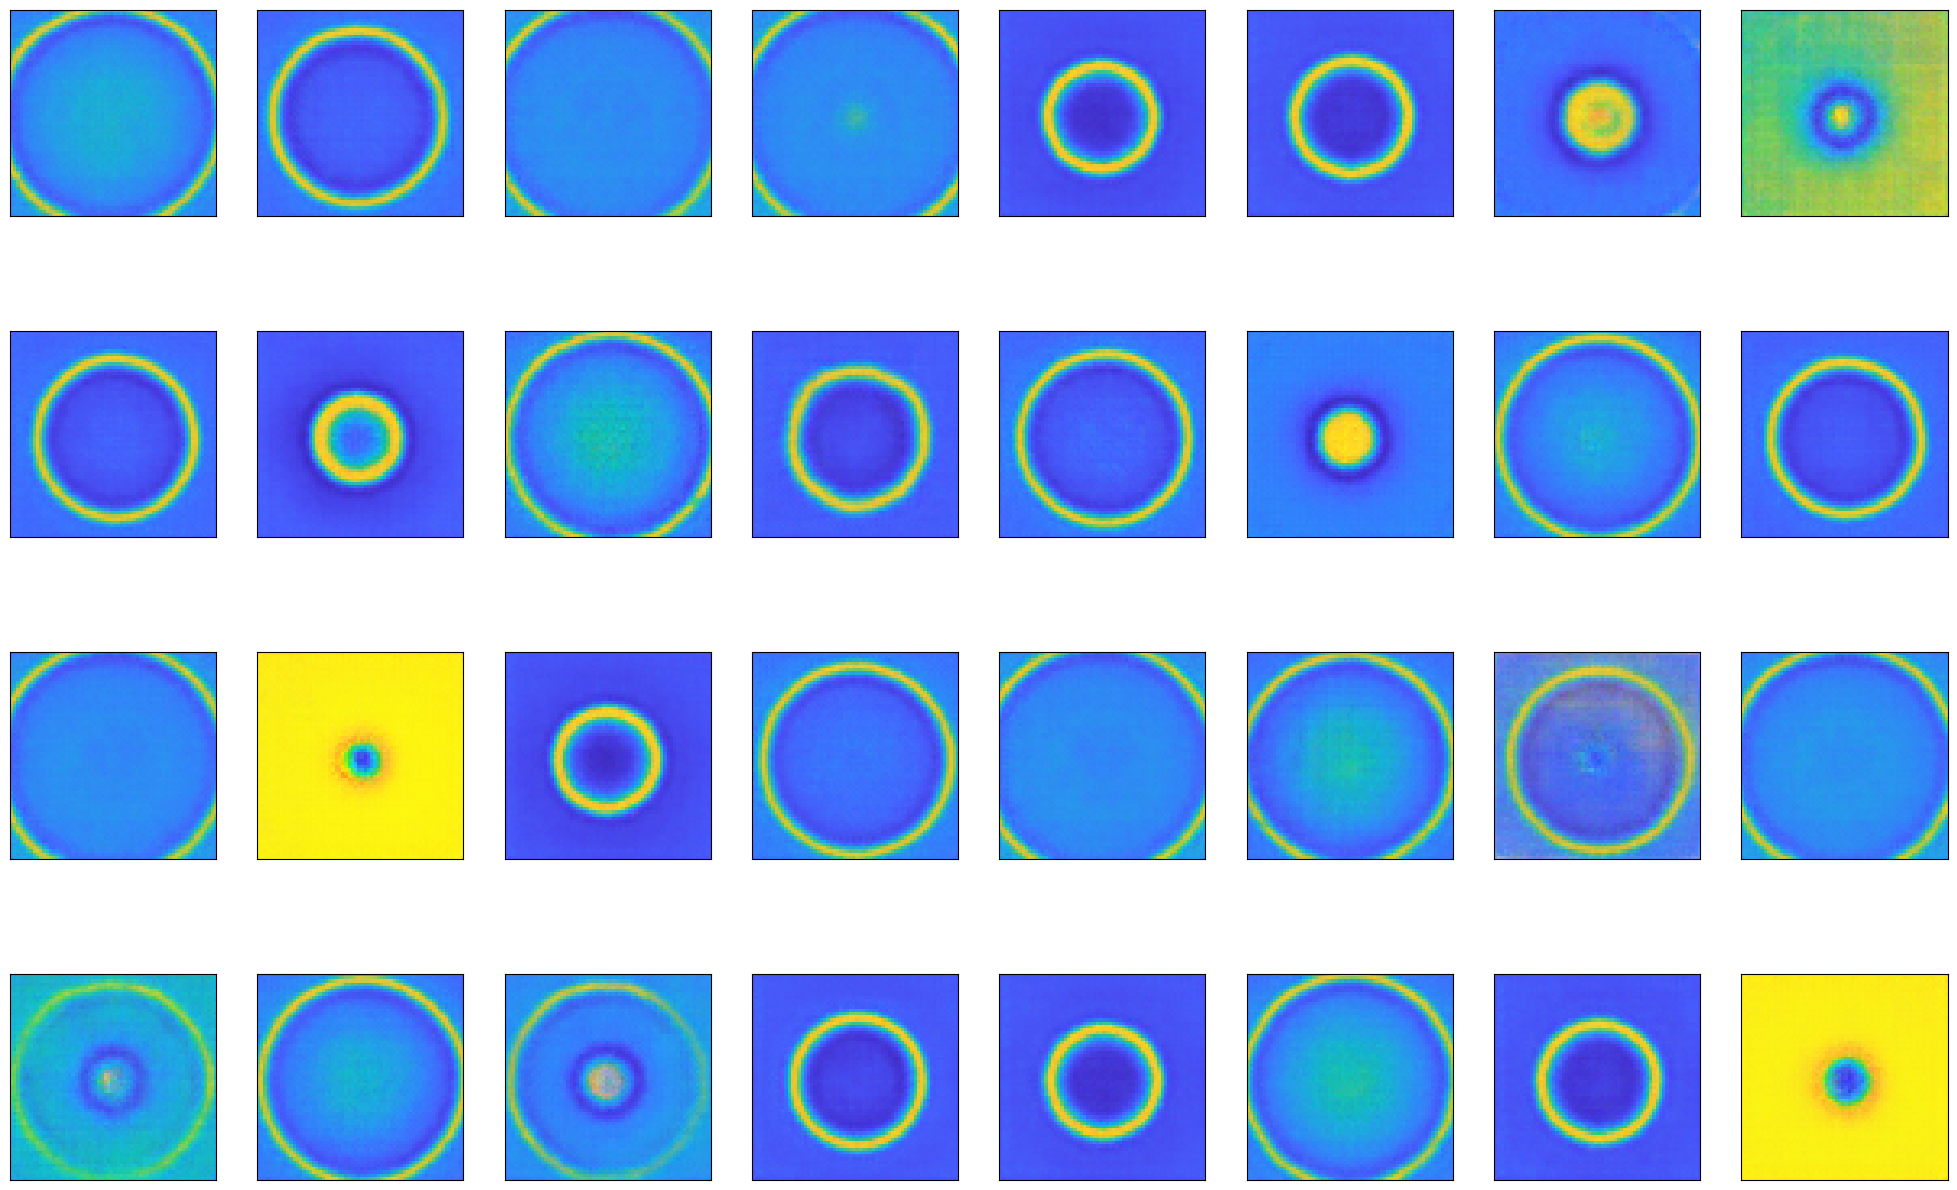

[602/1000][11/23] Loss_D: -0.8344 Loss_G: -211.7211
[602/1000][22/23] Loss_D: -0.8721 Loss_G: -205.1353
[603/1000][11/23] Loss_D: -3.5500 Loss_G: -206.8119
[603/1000][22/23] Loss_D: -2.4269 Loss_G: -210.0516
[604/1000][11/23] Loss_D: -4.0524 Loss_G: -215.5464
[604/1000][22/23] Loss_D: -1.9786 Loss_G: -207.8204
[605/1000][11/23] Loss_D: -0.2084 Loss_G: -205.4254
[605/1000][22/23] Loss_D: -1.6130 Loss_G: -210.1255
[606/1000][11/23] Loss_D: 1.7945 Loss_G: -210.8322
[606/1000][22/23] Loss_D: -2.3211 Loss_G: -208.8406
[607/1000][11/23] Loss_D: -1.2523 Loss_G: -204.1338
[607/1000][22/23] Loss_D: -1.7551 Loss_G: -211.5013
[608/1000][11/23] Loss_D: -5.0039 Loss_G: -202.3315
[608/1000][22/23] Loss_D: -4.4152 Loss_G: -209.4944
[609/1000][11/23] Loss_D: -7.7623 Loss_G: -215.1719
[609/1000][22/23] Loss_D: -7.4336 Loss_G: -209.2189
[610/1000][11/23] Loss_D: -2.6694 Loss_G: -203.7969
[610/1000][22/23] Loss_D: -0.8427 Loss_G: -215.1517
[611/1000][11/23] Loss_D: -3.5921 Loss_G: -223.2823
[611/1000][22

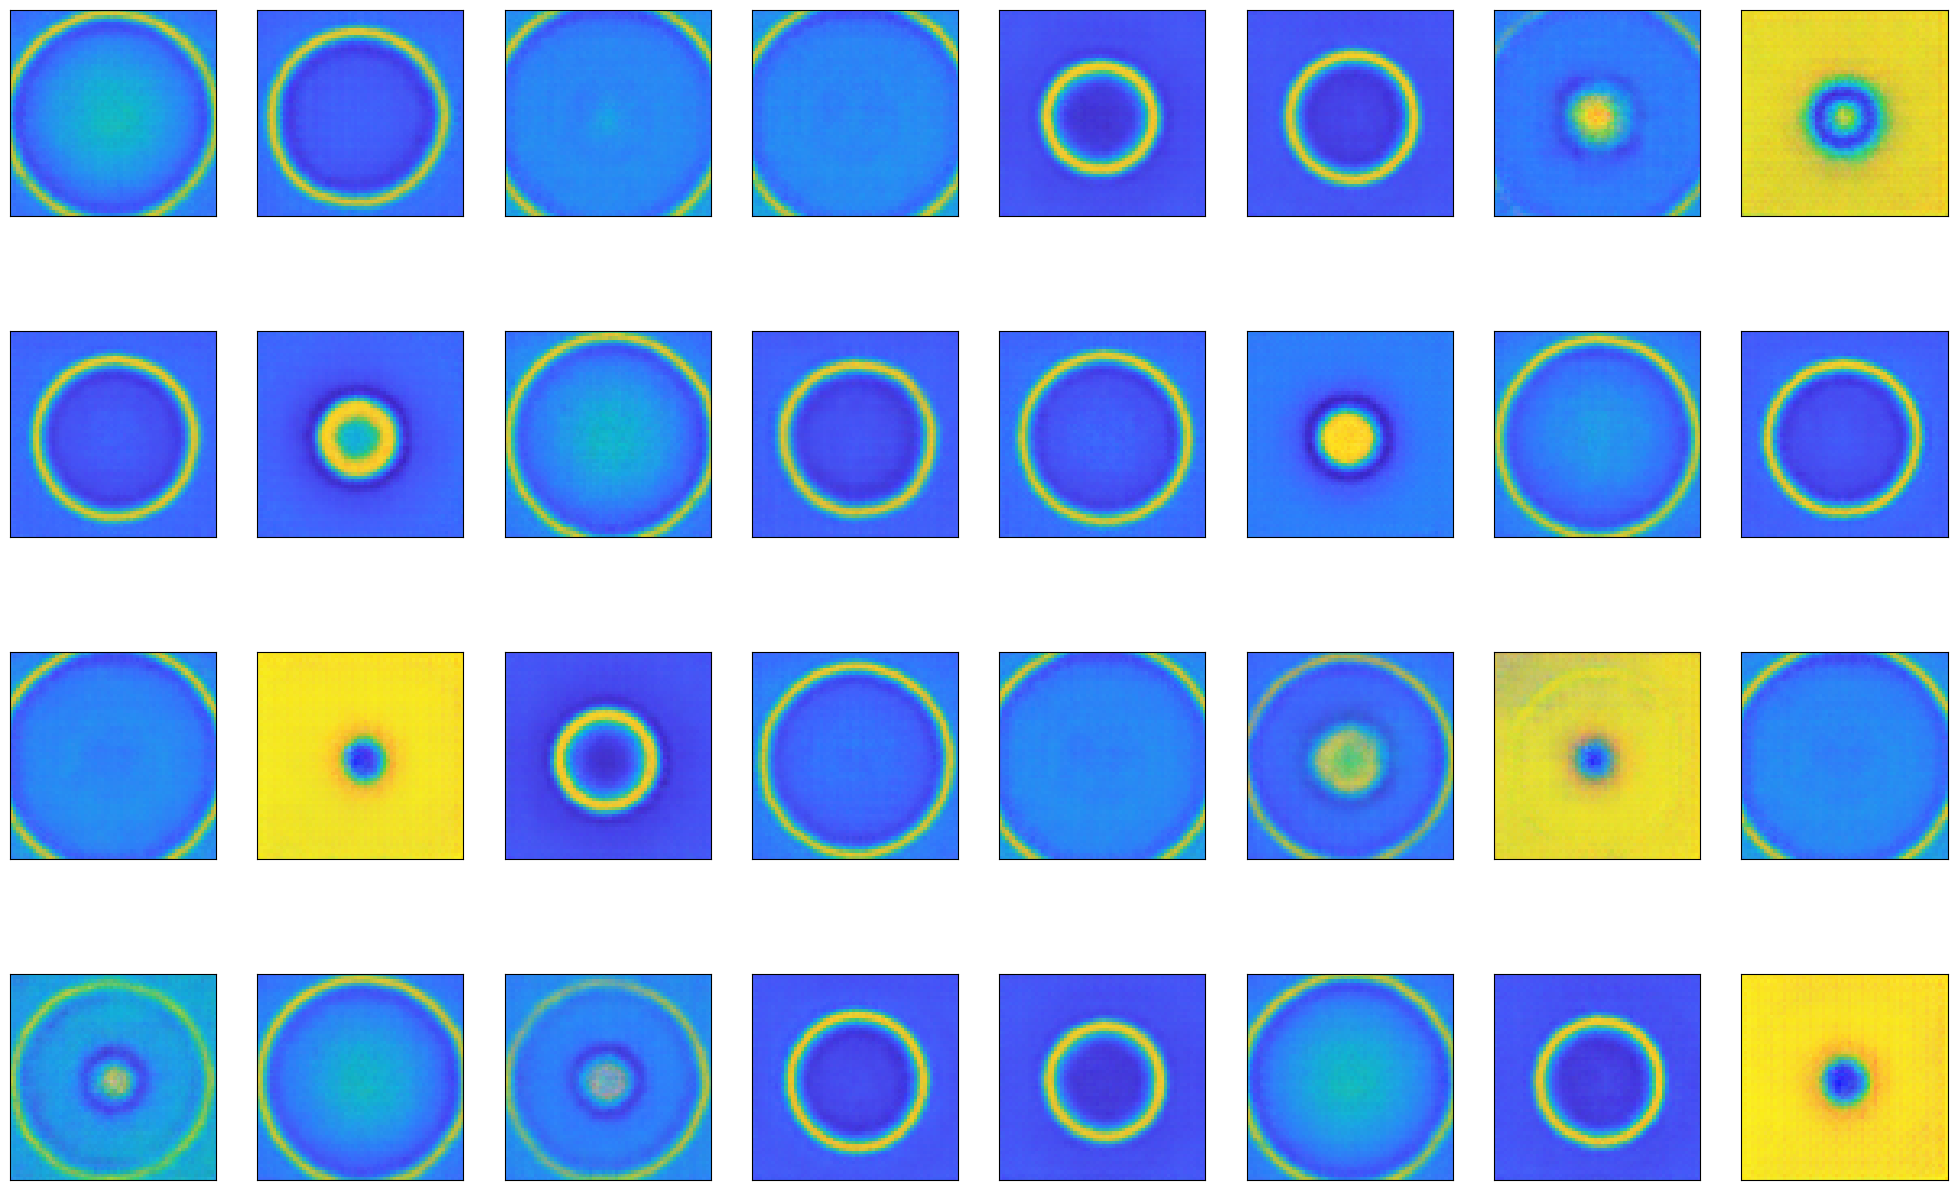

[702/1000][11/23] Loss_D: -3.7057 Loss_G: -214.7697
[702/1000][22/23] Loss_D: -5.1215 Loss_G: -214.8939
[703/1000][11/23] Loss_D: -2.2049 Loss_G: -221.3963
[703/1000][22/23] Loss_D: -5.8082 Loss_G: -216.6247
[704/1000][11/23] Loss_D: -2.2994 Loss_G: -216.7061
[704/1000][22/23] Loss_D: -0.7214 Loss_G: -215.5470
[705/1000][11/23] Loss_D: -4.2841 Loss_G: -206.5536
[705/1000][22/23] Loss_D: 1.0527 Loss_G: -219.5783
[706/1000][11/23] Loss_D: -5.8383 Loss_G: -214.5627
[706/1000][22/23] Loss_D: -2.6043 Loss_G: -216.0006
[707/1000][11/23] Loss_D: -5.8080 Loss_G: -206.4314
[707/1000][22/23] Loss_D: -5.9986 Loss_G: -208.3446
[708/1000][11/23] Loss_D: -2.7493 Loss_G: -212.4515
[708/1000][22/23] Loss_D: -5.4402 Loss_G: -211.4488
[709/1000][11/23] Loss_D: -0.2104 Loss_G: -211.7985
[709/1000][22/23] Loss_D: -3.9596 Loss_G: -217.7279
[710/1000][11/23] Loss_D: -7.1063 Loss_G: -212.8904
[710/1000][22/23] Loss_D: -6.5371 Loss_G: -213.0442
[711/1000][11/23] Loss_D: -4.1004 Loss_G: -207.7909
[711/1000][22

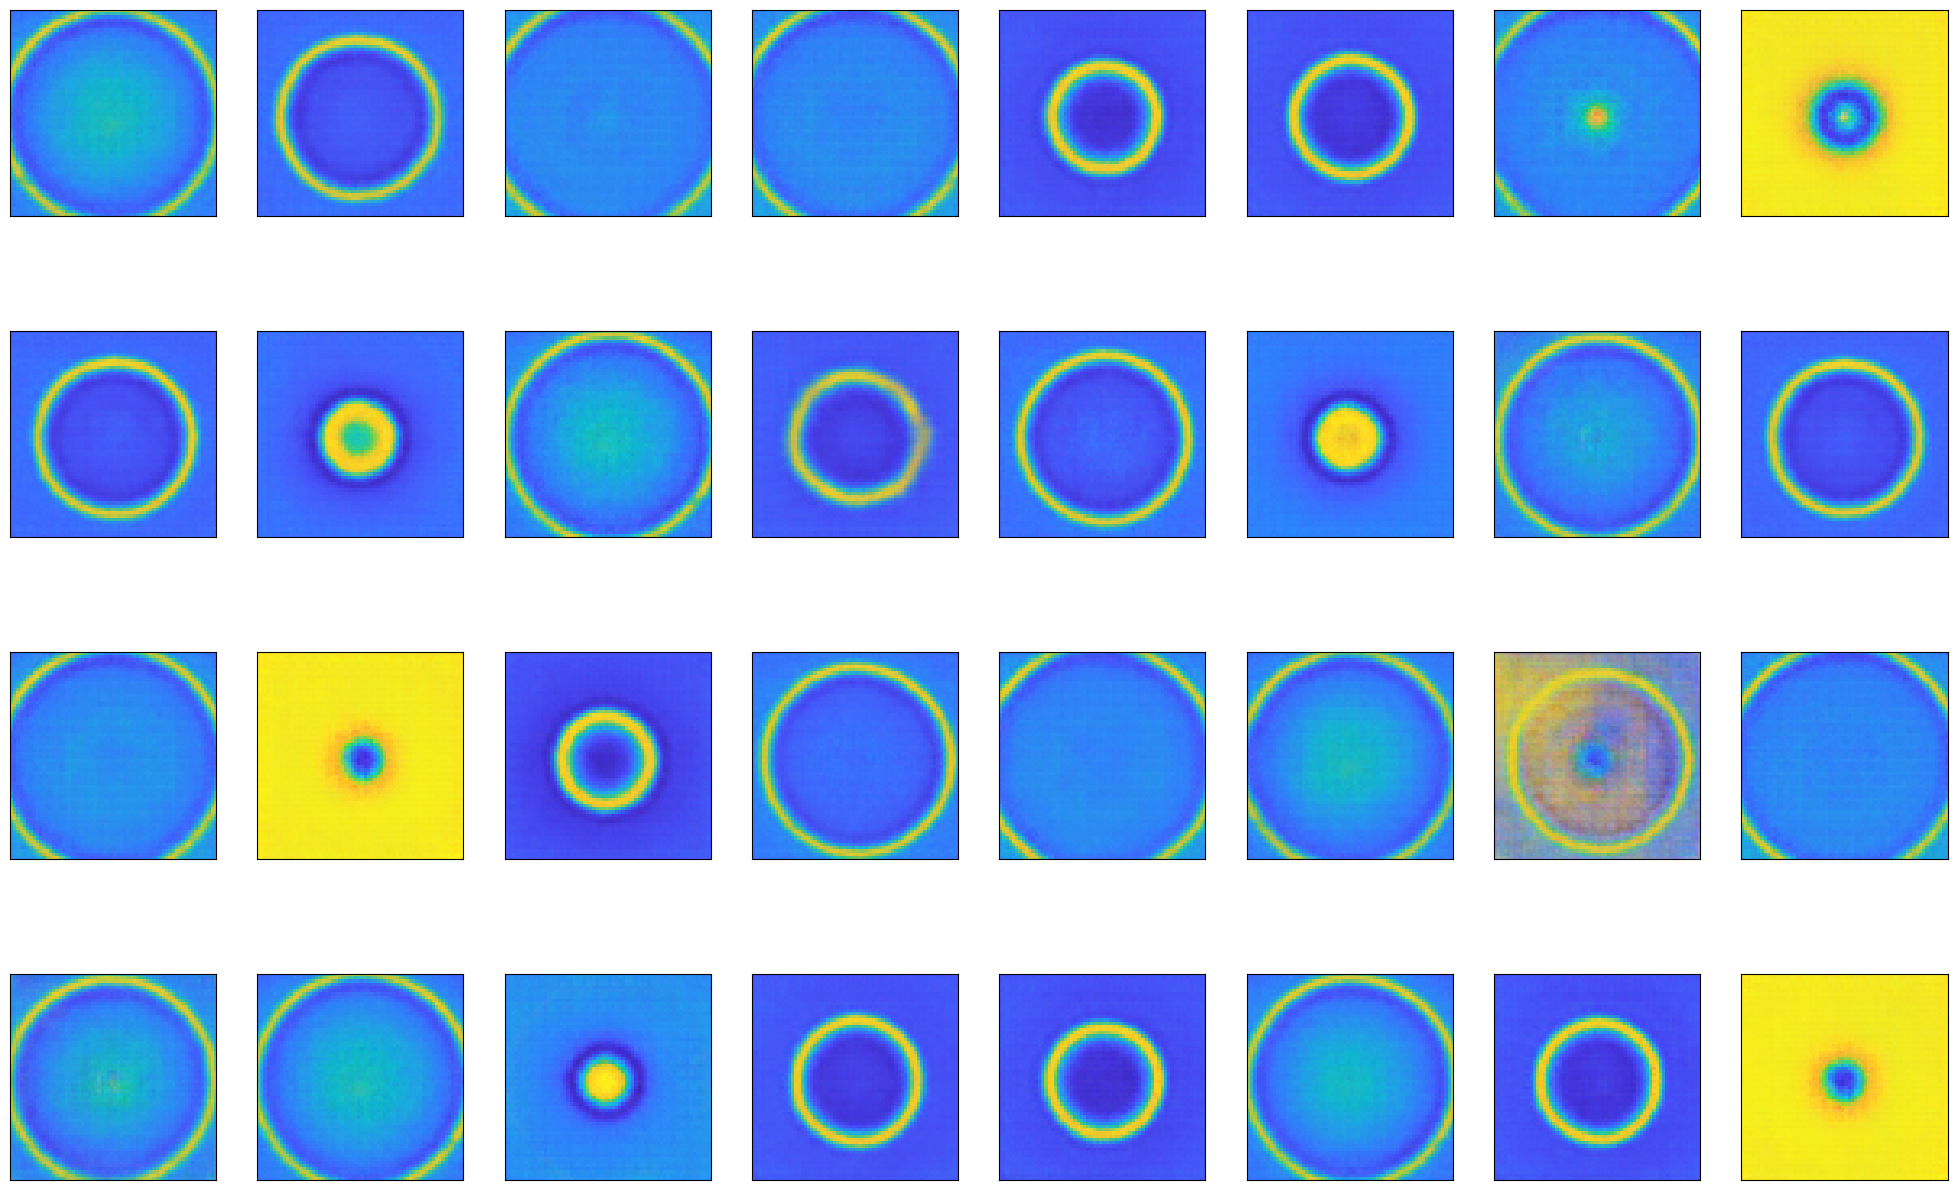

[802/1000][11/23] Loss_D: -2.6256 Loss_G: -216.6674
[802/1000][22/23] Loss_D: -7.4262 Loss_G: -214.3904
[803/1000][11/23] Loss_D: -4.6605 Loss_G: -217.4214
[803/1000][22/23] Loss_D: 0.9556 Loss_G: -218.7676
[804/1000][11/23] Loss_D: -5.0333 Loss_G: -214.2880
[804/1000][22/23] Loss_D: 1.6266 Loss_G: -220.8085
[805/1000][11/23] Loss_D: -3.9263 Loss_G: -218.1260
[805/1000][22/23] Loss_D: -8.3824 Loss_G: -211.9485
[806/1000][11/23] Loss_D: -6.7334 Loss_G: -212.0608
[806/1000][22/23] Loss_D: -3.8457 Loss_G: -217.3385
[807/1000][11/23] Loss_D: -3.3695 Loss_G: -214.0987
[807/1000][22/23] Loss_D: -11.7160 Loss_G: -207.5623
[808/1000][11/23] Loss_D: -2.8915 Loss_G: -217.5980
[808/1000][22/23] Loss_D: 0.7202 Loss_G: -210.6055
[809/1000][11/23] Loss_D: -3.8603 Loss_G: -217.4656
[809/1000][22/23] Loss_D: -5.4020 Loss_G: -216.3863
[810/1000][11/23] Loss_D: -3.7007 Loss_G: -211.6868
[810/1000][22/23] Loss_D: -7.4263 Loss_G: -217.0568
[811/1000][11/23] Loss_D: -6.6435 Loss_G: -209.6122
[811/1000][22/

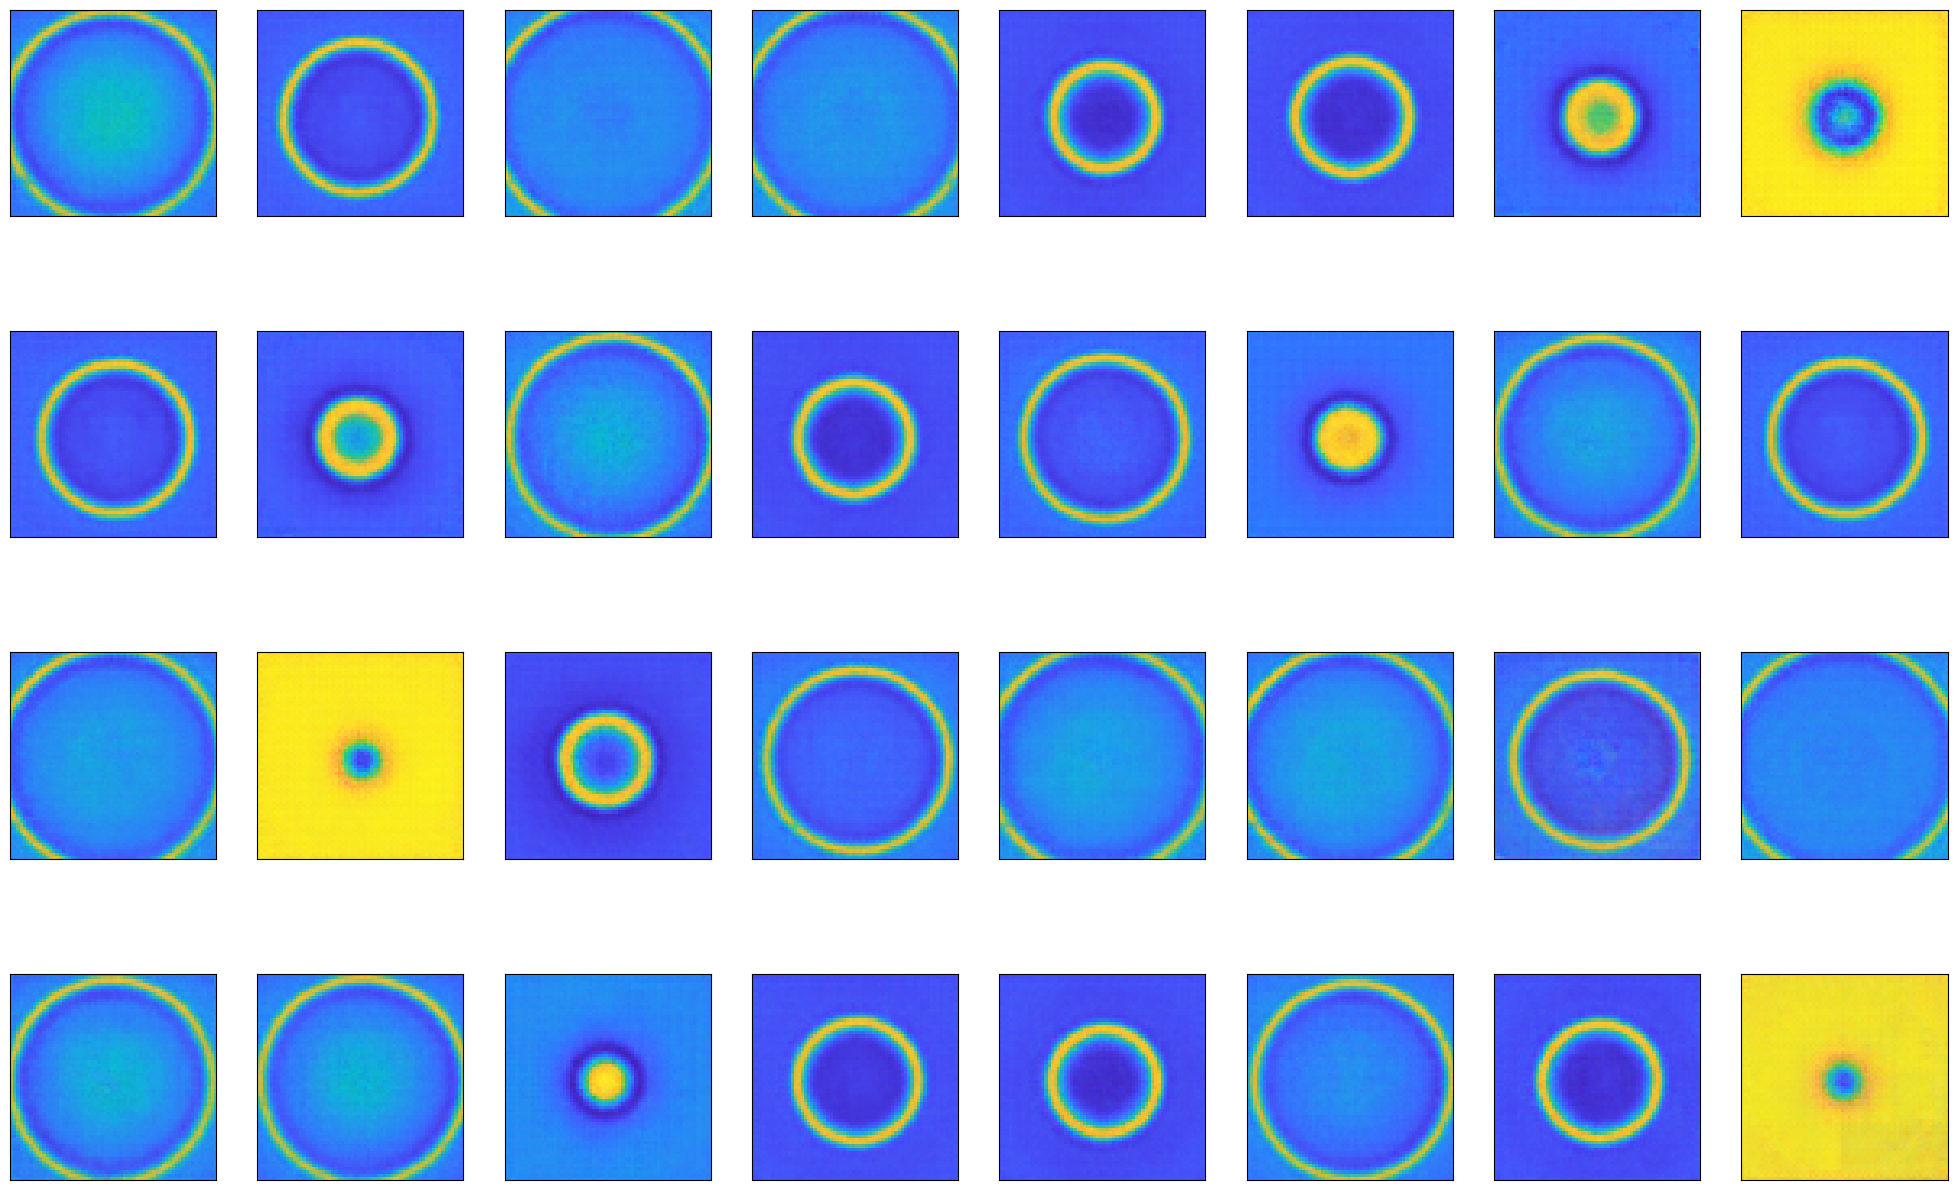

[902/1000][11/23] Loss_D: 2.2443 Loss_G: -228.6146
[902/1000][22/23] Loss_D: -7.4262 Loss_G: -219.2600
[903/1000][11/23] Loss_D: -0.5135 Loss_G: -226.0750
[903/1000][22/23] Loss_D: -2.0906 Loss_G: -228.0655
[904/1000][11/23] Loss_D: -5.4175 Loss_G: -223.2277
[904/1000][22/23] Loss_D: -6.2866 Loss_G: -231.3077
[905/1000][11/23] Loss_D: -2.7690 Loss_G: -231.6746
[905/1000][22/23] Loss_D: -4.1104 Loss_G: -226.7912
[906/1000][11/23] Loss_D: -3.8713 Loss_G: -230.1033
[906/1000][22/23] Loss_D: 0.3277 Loss_G: -231.2134
[907/1000][11/23] Loss_D: -6.5599 Loss_G: -211.7312
[907/1000][22/23] Loss_D: -2.4538 Loss_G: -228.1422
[908/1000][11/23] Loss_D: -4.9872 Loss_G: -229.2008
[908/1000][22/23] Loss_D: 0.4588 Loss_G: -225.0983
[909/1000][11/23] Loss_D: -4.5497 Loss_G: -224.2291
[909/1000][22/23] Loss_D: -0.6658 Loss_G: -224.4842
[910/1000][11/23] Loss_D: 0.7781 Loss_G: -230.0066
[910/1000][22/23] Loss_D: -4.2241 Loss_G: -226.8162
[911/1000][11/23] Loss_D: -10.1917 Loss_G: -226.4831
[911/1000][22/2

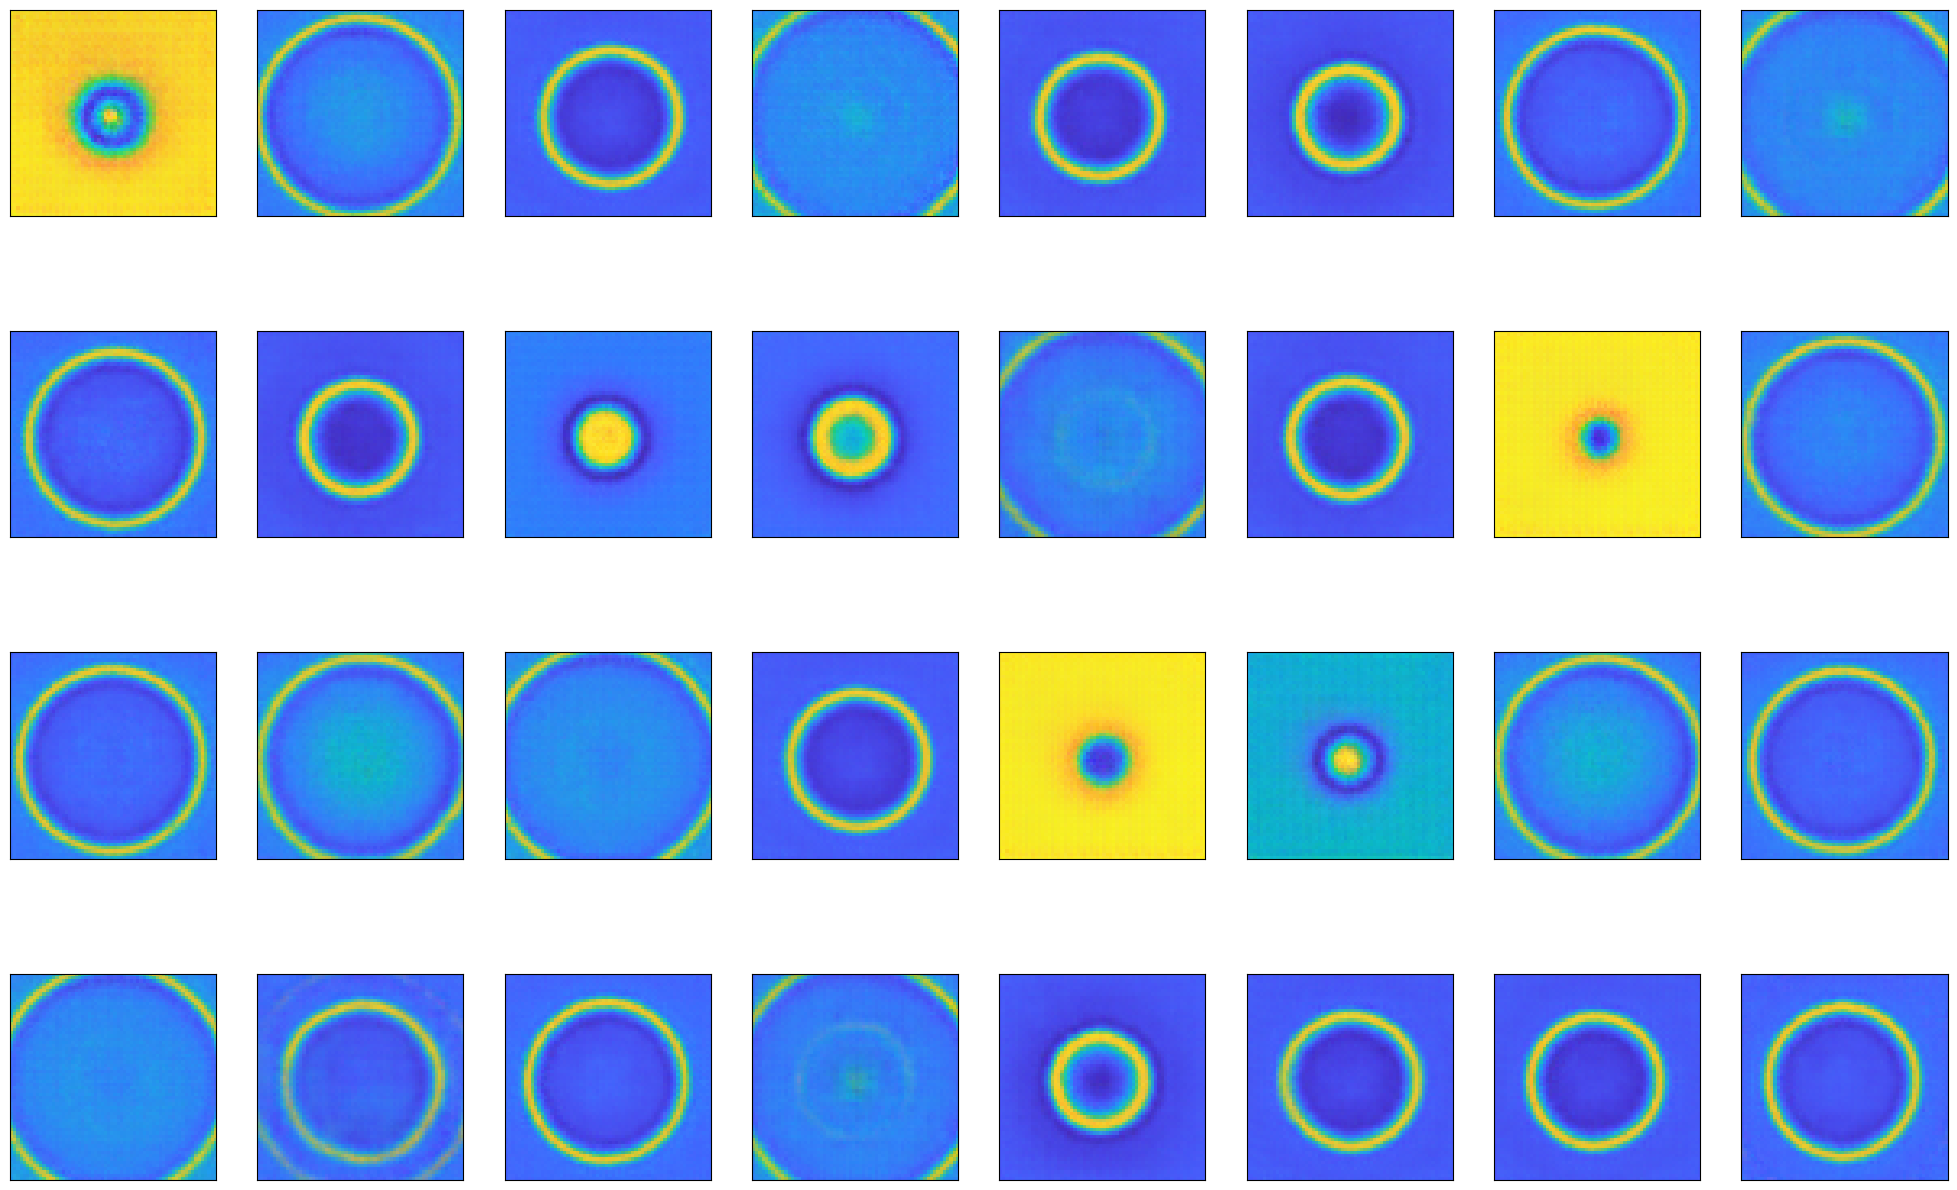

**********

 Saving Images with lr = 0.001, batch_size=13, epochs=1000, nz=30, lambda_gp = 10, critic_size = 2
**********


In [10]:
import torch
# Iterate through combinations of parameters
for lambda_gp in lambda_gp_sizes:
    for num_disc_gen in num_disc_gen_sizes:
        for lr in lr_sizes:
            for batch_size in batch_sizes:
                for epochs in epochs_values:
                    for nz in nz_values:
                        # Training parameters
                        print(f"\nTraining with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}, lambda_gp = {lambda_gp}, critic_size = {num_disc_gen}")
                        beta1 = 0

                        # Labeling for discriminator
                        real_label = 0.5
                        fake_label = 0

                        # Setting up the device for training
                        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

                        # Run your training and evaluation code
                        trainData(batch_size, nz, epochs, lr, lambda_gp, num_disc_gen)

#             # Check if current configuration is better than the previous best
#             if accuracy > best_accuracy:
#                 best_accuracy = accuracy
#                 best_parameters = {'batch_size': batch_size, 'epochs': epochs, 'nz': nz}

# Print the best configuration
# print(f"\nBest Configuration: {best_parameters}, Best Accuracy: {best_accuracy}")
